

## Davide Fassino, Andrea Pastore
### Politecnico di Torino, A.Y. 2021/2022


### Introduction
The main objective of this Homework is to apply the Principal Component Analysis (PCA) to a real dataframe collected by students of the Statistics class at the Faculty of Social and Economic Sciences of the University of Bratislava. 

The analysis starts from two dataframes contained in our *data* folder. The first one is called *columns_hw.csv* and it contains the original questions in the survey and a shortened version of all the questions. The second file, *responses_hw.csv*, is instead the collection of the responses of the 1010 students interviewed. The responses can either be a numerical answer to a quantification question, i.e. "How much do you like this pizza from $1.0$ to $5.0$?", or a categorical answer to a multiple choice question, i.e. "Are you a male or a female?".

### 1. Preparation (Setting random State)
First of all, we import the packages that will be useful to start the analysis. 

In particular we use *numpy* for dealing with arrays, *pandas* for dealing with dataframes and *sklearn* for using the already-implemented functions for the *Principal Component Analysis (PCA)* and the *k-means* algorithm.

Then, as requested, we set the *random seed* for the whole homework as the sum of our students IDs, which is 287851 + 289905.

In [1]:
%matplotlib widget

# Importing the packages

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.lines import Line2D
#import yaml
#from IPython.display import display

#try:
#    from yaml import CLoader as Loader, CDumper as Dumper
#except ImportError:
#    from yaml import Loader, Dumper

#pd.options.display.max_columns = 200

# Setting the random seed
rs = 287851 + 289905
np.random.seed(rs)

### Exercise 1 (Loading and Preparing the Data)

Let's load the dataframes *columns_hw.csv* and *responses_hw.csv* using the function *read_csv* in *pandas*.
We used the function *display()* in order to see what types of questions and answers were present in the dataframes.

In [2]:
# Loading the dataframes
columns_hw_path = 'data/columns_hw.csv' 
responses_hw_path = 'data/responses_hw.csv' 

columns_hw_df = pd.read_csv('data/columns_hw.csv')  
responses_hw_df = pd.read_csv('data/responses_hw.csv')

# Displaing of the dataframes
# display(columns_hw_df)
# display(responses_hw_df)  

FileNotFoundError: [Errno 2] No such file or directory: 'data/columns_hw.csv'

From a brief inspection of the dataframes, we find that in *responses_hw_df* some of the answers of the students are missing entries. In particular, thanks to the following code, we know that $336$ out of $1010$ students missed (or misentered) at least one entry.

In [ ]:
# Checking the number of non-complete answers
responses_bool = responses_hw_df.isna().values

d = 0
for i in range(len(responses_bool)):
    if True in responses_bool[i,:]: d = d+1

# Displaying the number of the non-complete

print("Number of students that missed at least one entry in the survey: " + str(d))

Number of students that missed at least one entry in the survey: 336


If we decide to ignore the uncomplete rows of *responses_hw_df*, we would have deleted $\simeq 1/3$ of the total answers, which is unacceptable.

Thus, we decided to insert in the missing positions:

1. The **mean value** of the answer if the missing entry is *numerical*;

1. The **mode** of the answer if the missing entry is *categorical*.

In both cases, we compute the **mean value** and the **mode** by considering the answers of the other students to the same question.

This strategy allows us to consider as valid all the answers, even if someone did not answer all the questions, and, at the same time, we do not increase the *variance* of the dataset. 

In [ ]:
# Categorical answers in repsonses_hw_df
cat_feature = responses_hw_df.select_dtypes(exclude=np.number).columns

# Numerical answers in repsonses_hw_df
num_feature = responses_hw_df.select_dtypes(np.number).columns    

# Update the dataframe with the new mean informations
updated_df = responses_hw_df
for k in cat_feature:
    updated_df[k] = updated_df[k].fillna(axis=0, value=min(updated_df[k].mode()))

for k in num_feature:
    updated_df[k] = updated_df[k].fillna(axis=0, value=updated_df[k].mean())

responses_hw_df = updated_df

We now proceed to split *responses_hw_df* into three sub-dataframes:

1. *entertainment_df*, which contains the answers for the questions that are labeled *entertainment*, corresponding to the first 63 columns of *responses_hw_df*;

1. *personality_df*,  which contains the answers for the questions that are labeled *personality_df*, corresponding to the columns from 63 to 140 of *responses_hw_df*;

1. *demography_df*, which contains some demographic data of the students of the survey, corresponding to the last 10 columns.

Using the random seed previusly setted, we drop 5 columns from *entertainment_df* and 10 from *personality_df*.
We then define a dataframe called *workdf_tot* which is the concatenation of *entertainment_df* and *personality_df*.

Since our random seed is even, we define *workdf_1* as *entertainment_df*. 
This will be the dataframe that we will use for the first part of the Homework.

In [ ]:
# Splitting the dataframe into the 3 sub-dataframes
entertainment_cols = responses_hw_df.columns.to_list()[0:63]  
personality_cols = responses_hw_df.columns.to_list()[63:(63+77)] 
demography_cols = responses_hw_df.columns.to_list()[(63+77):]

entertainment_df = responses_hw_df.loc[:,entertainment_cols]
personality_df = responses_hw_df.loc[:,personality_cols]
demography_df = responses_hw_df.loc[:,demography_cols]

# Dropping 5 random columns (questions) from the entertainment_df and personality_df
entertainment_df =entertainment_df.drop(entertainment_df.sample(n=5,axis=1,random_state=rs),axis=1)
personality_df = personality_df.drop(personality_df.sample(n=10,axis=1,random_state=rs),axis=1)

concat_df = pd.concat([entertainment_df, personality_df], axis=1)

# Definition of the Homework dataframes
workdf_1 = entertainment_df
workdf_tot = concat_df

# Displaying the Homework dataframes 
# display(workdf_1)
# display(workdf_tot)


### Exercise 2 (Preprocessing)

Let's now analyse the dataframes *workdf_1* and *workdf_tot*, in order to see if any preprocessing technique is necessary.

1. ***workdf_1***. Since in our case all the entries are *numerical*, we do not need any encoding procedure. Moreover, all the features have values from '1.0' to '5.0'. For this reason, it is not necessary to normalize the values, since they all have the same order of magnitude.

1. ***workdf_tot***. In this case, the entries called (in short) as *'Smoking'*, *'Alcohol'*, *'Punctuality'* and *'Internet usage'* are ***categoricals***. Since the expected answers are incremental, we can encode them in a categorical way. We see that the possible answers to these questions are less than five, so we enumerete them from $1.0$ to the number of the possible answers ($3.0$ or $4.0$). We can also see that all the possible answers have the same order of magnitude, so a normalization is, again, not necessary.

We decided, as a "rule of thumb", to encode the answers based on how much they answers *positevely* the question. For instance, if the question is related to *"Smoking"*, then we will give the maximum value to *"current smoker"* and the minimal value to *"never smoked"*.

In [ ]:
# Encoding the textual columns in workdf_tot using dictionaries
# display(workdf_tot)

Smoking_dict = {
    'current smoker': 4.0,
    'former smoker': 3.0,
    'tried smoking': 2.0,
    'never smoked': 1.0
}

Alcohol_dict = {
    'drink a lot': 3.0,
    'social drinker': 2.0,
    'never': 1.0
}

Punctuality_dict = {
    'late': 1.0,
    'on time': 2.0,
    'early': 3.0
}

Internet_usage_dict = {
    'no time at all': 1.0,
    'less than an hour a day': 2.0, 
    'few hours a day': 3.0,
    'most of the day': 4.0
}

# Modifying workdf_tot using the new encoding
workdf_tot['Smoking'] = [Smoking_dict[t] for t in workdf_tot['Smoking'].values]
workdf_tot['Alcohol'] = [Alcohol_dict[t] for t in workdf_tot['Alcohol'].values]
workdf_tot['Punctuality'] = [Punctuality_dict[t] for t in workdf_tot['Punctuality'].values]
workdf_tot['Internet usage'] = [Internet_usage_dict[t] for t in workdf_tot['Internet usage'].values]

# Displaying workdf_tot
# display(workdf_tot)


### Exercise 3 (Computation of the PCs)
 
Let's use the package *sklearn* to perform the PCA on *workdf_1*. As the next step, we want to find $m$ which is the number of Principal Components needed to represent at least the $30\%$ of the total variance. Firstly, we plot the cumulative explained variance for all the Principal Components. 

In [3]:
pca_full = PCA() 
pca_full.fit(workdf_1.values) 


plt.figure(figsize=(12, 6))
plt.plot(np.insert(np.cumsum(pca_full.explained_variance_ratio_), 0, 0))
plt.title('CUMULATIVE EXPLAINED VARIANCE (ALL PCs)')
plt.xticks(ticks=np.arange(1, pca_full.n_features_ + 1, 5), 
           labels=[f'PC{i}' for i in range(1, pca_full.n_features_ + 1, 5)],
           rotation=45)
plt.xlabel('Principal Components')
plt.ylabel('Cumulative explained variance (%)')
plt.grid()
plt.show()

print('First 5 principal components explained variance:' ,np.cumsum(pca_full.explained_variance_ratio_)[:5])

m = 4

NameError: name 'workdf_1' is not defined

We see that the first $4$ components can reprent the $31.48$%, allowing us to set $m = min(5,4)=4$.
Having selected $m = 4$, we plot the cumulative curve and the barplot with respect to PC1, ..., PC4.

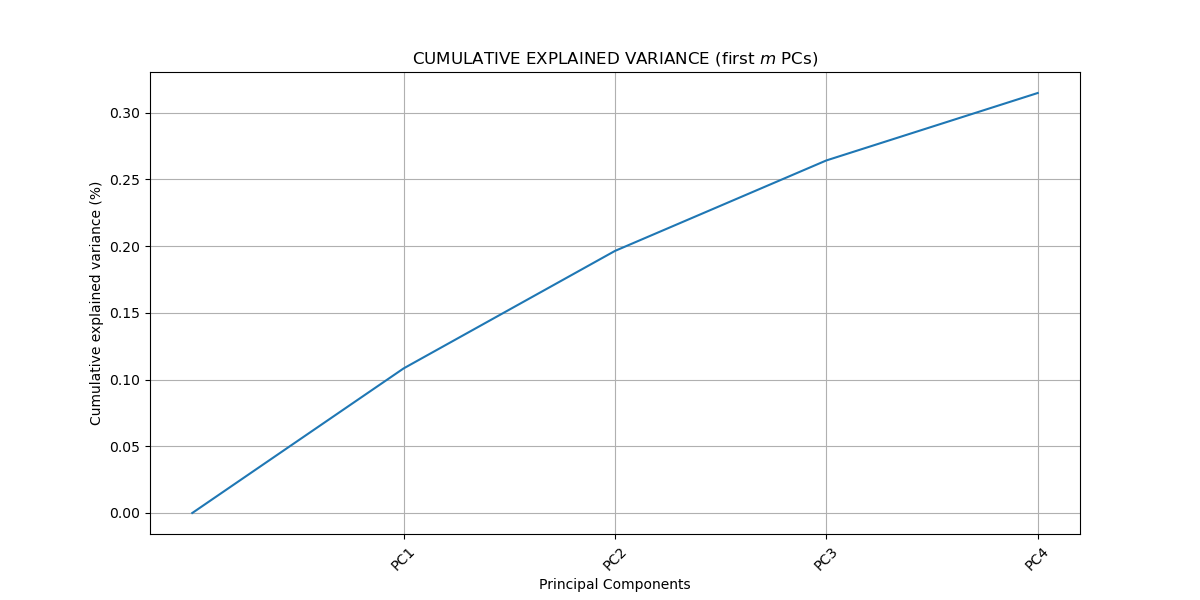

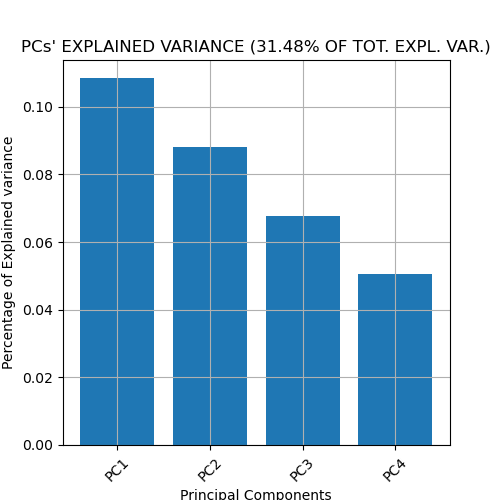

In [105]:
# Initialize the PCA
pca = PCA(n_components=m)

# fitting the pca with the workdf_1 dataframe
pca.fit(workdf_1.values)

# Compute the cumulative percentage of explained variance w.r.t. PC1 to PC4(ROUNDED TO 2 DECIMALS)
round_expl_var_ratio = np.round(pca.explained_variance_ratio_.sum() * 100, decimals=2)

# Plotting the curve of the cumulative percentage of explained variance
plt.figure(figsize=(12, 6))
plt.plot(np.insert(np.cumsum(pca.explained_variance_ratio_), 0, 0))
plt.title('CUMULATIVE EXPLAINED VARIANCE (first $m$ PCs)')
plt.xticks(ticks=np.arange(1, m + 1), 
           labels=[f'PC{i}' for i in range(1, m+ 1)],
           rotation=45)
plt.xlabel('Principal Components')
plt.ylabel('Cumulative explained variance (%)')
plt.grid()
plt.show()

# THE BARPLOT
plt.figure(figsize=(5, 5))
plt.bar(range(1, m + 1), pca.explained_variance_ratio_)
plt.title(f"PCs' EXPLAINED VARIANCE ({round_expl_var_ratio}% OF TOT. EXPL. VAR.)")
plt.xticks(ticks=np.arange(1, m + 1), 
           labels=[f'PC{i}' for i in range(1, m + 1)],
           rotation=45)
plt.xlabel('Principal Components')
plt.ylabel('Percentage of Explained variance')
plt.grid()
plt.show()

### Exercise 4 (Interpretation of the PCs)

In order to understand the significance of the Principal Components that we have found in the previuos points, we plot them highlighting the features that are the most expressed.
Through the barplot of the $m=4$ PCs, we can give an interpretation of the Principal Component by looking at which answers are more expressed, i.e. which bars are the tallest (either positively or negatively).

We have defined a positive parameter $\varepsilon$ which works as a *threshold* for the features. In particular, if a bar is not taller than $\varepsilon$ we do not consider that feature to be particularly expressed in the Principal Component. Therefore, we will give an interpretation of the PCs by only considering the features more expressed than $\varepsilon$. We choose to use $\varepsilon = \sqrt{1/\#\text{features}}$. 

Among the more expressed features, we will use the highest ones in order to give names to the Principal Components. In particular, if these features are positive we will use the symbol (+) in the name, and if they are negative we'll use the (-).

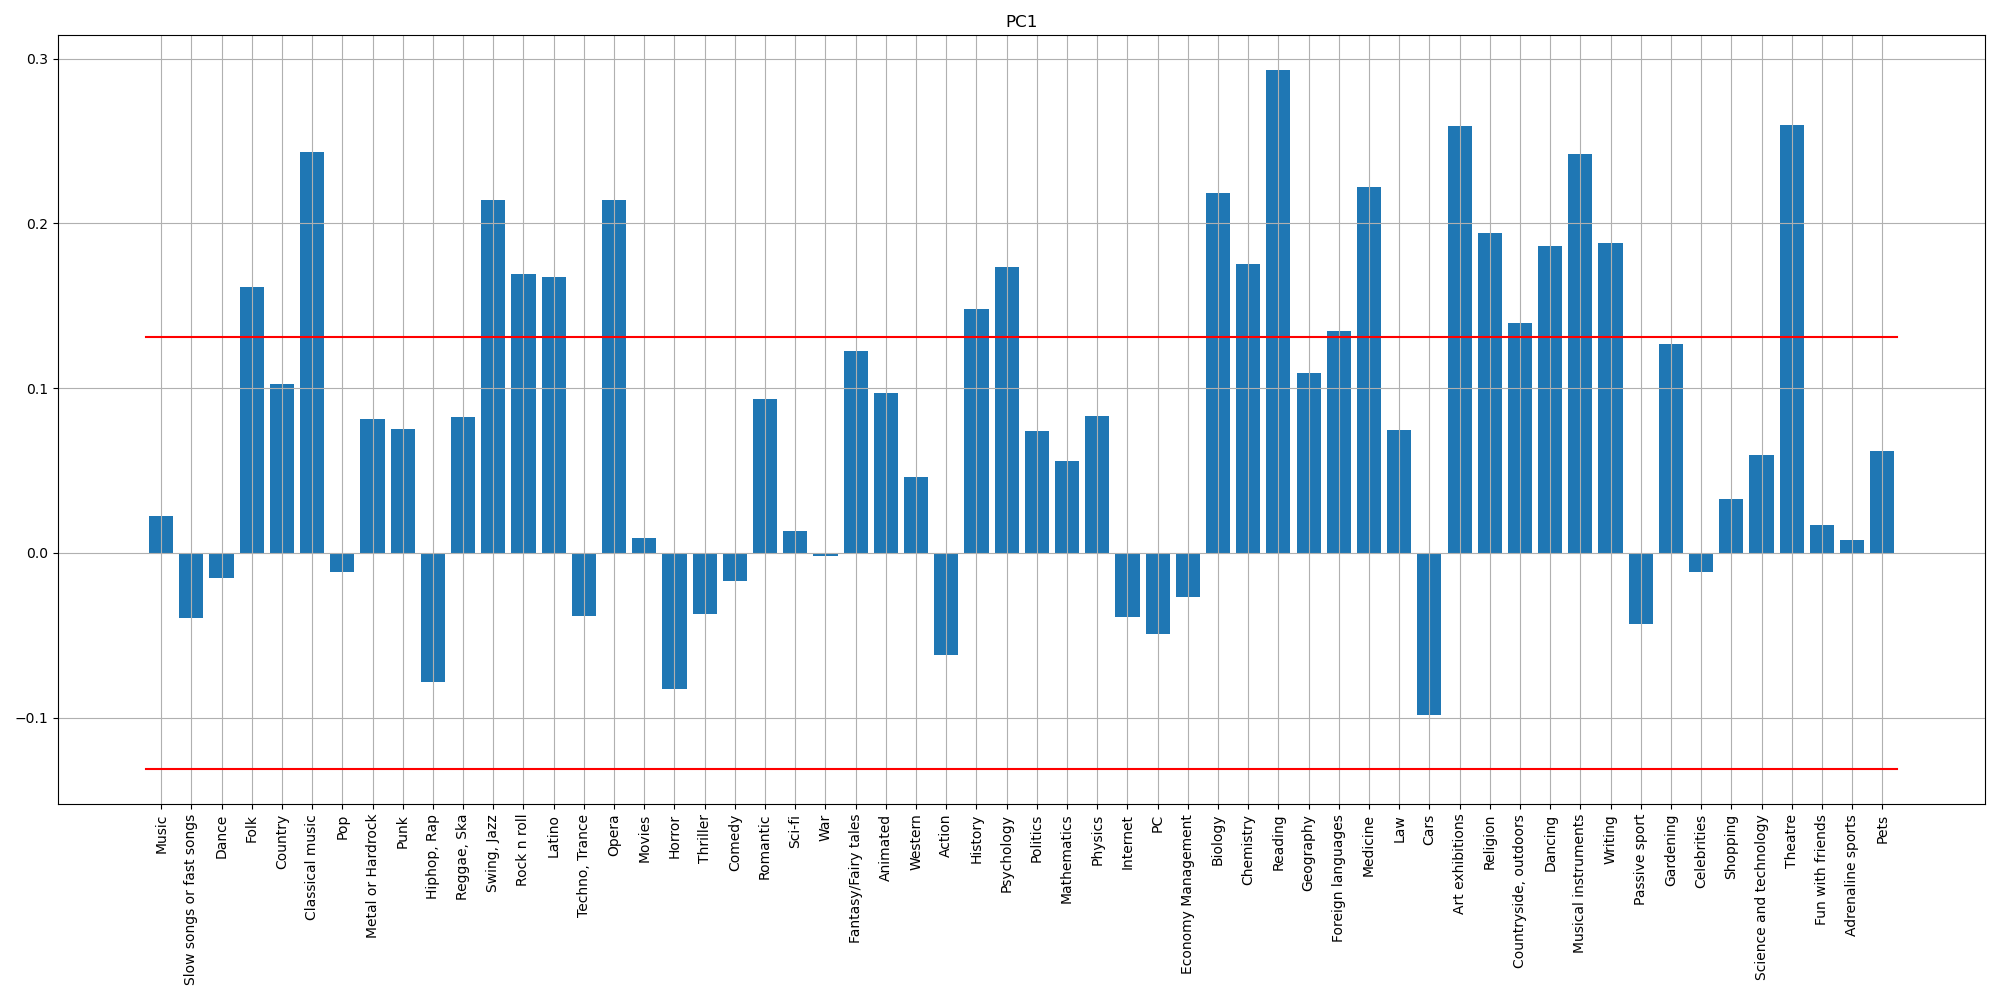


****************** PC1 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Folk', 'Classical music', 'Swing, Jazz', 'Rock n roll', 'Latino', 'Opera', 'History', 'Psychology', 'Biology', 'Chemistry', 'Reading', 'Foreign languages', 'Medicine', 'Art exhibitions', 'Religion', 'Countryside, outdoors', 'Dancing', 'Musical instruments', 'Writing', 'Theatre']

HIGH-VALUED NEGATIVE COMPONENTS: []
*********************************************



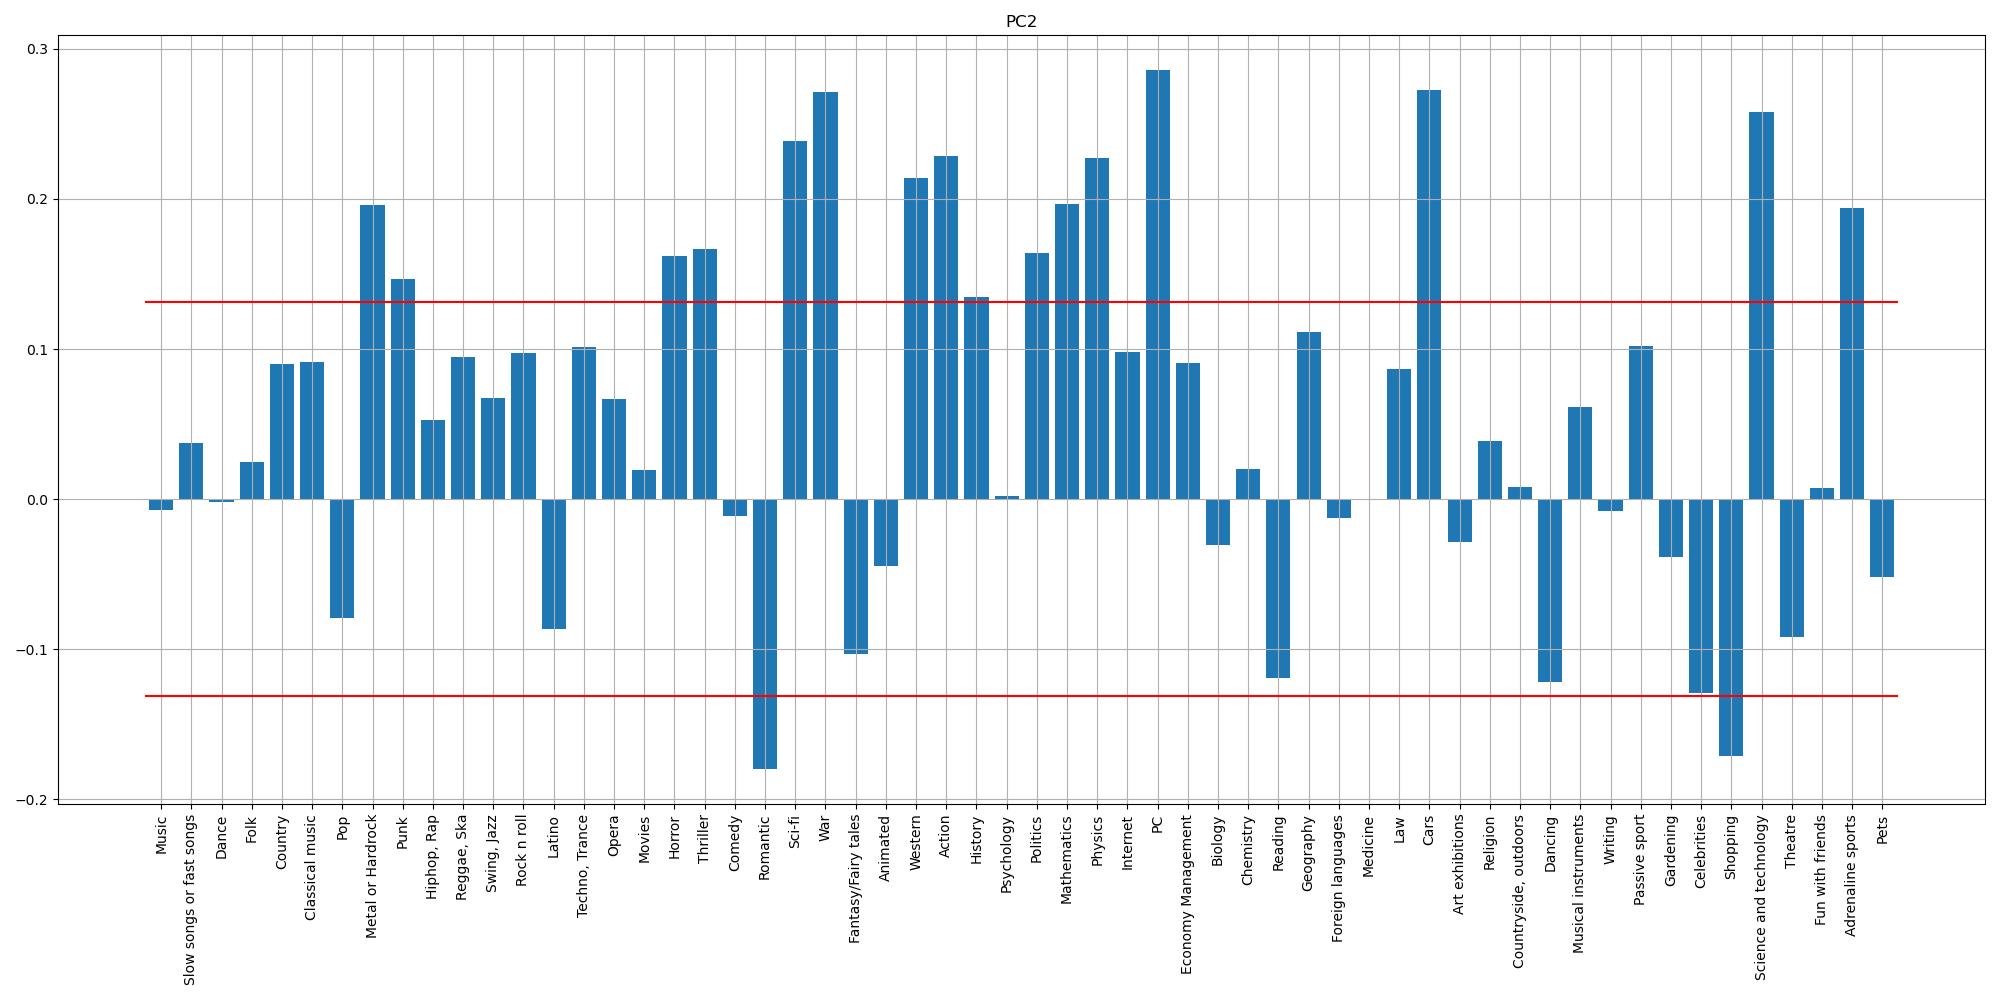


****************** PC2 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Metal or Hardrock', 'Punk', 'Horror', 'Thriller', 'Sci-fi', 'War', 'Western', 'Action', 'History', 'Politics', 'Mathematics', 'Physics', 'PC', 'Cars', 'Science and technology', 'Adrenaline sports']

HIGH-VALUED NEGATIVE COMPONENTS: ['Romantic', 'Shopping']
*********************************************



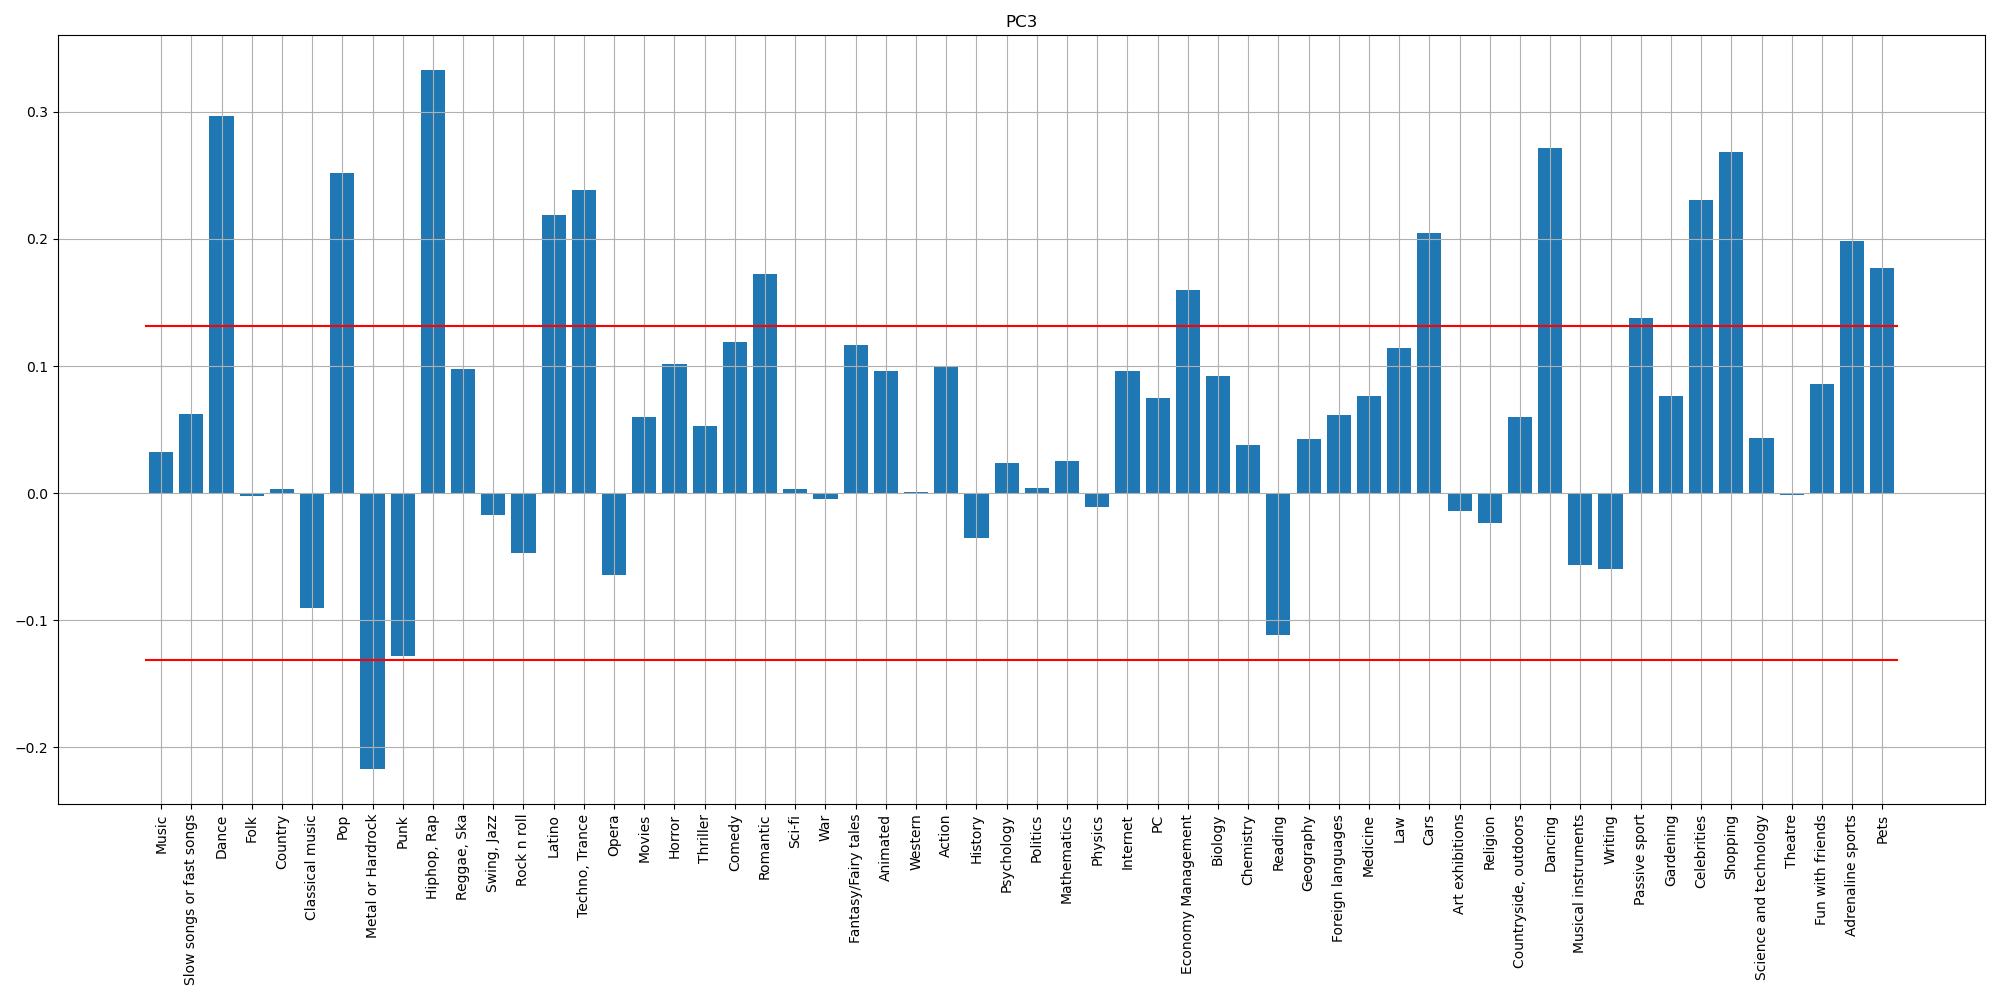


****************** PC3 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Dance', 'Pop', 'Hiphop, Rap', 'Latino', 'Techno, Trance', 'Romantic', 'Economy Management', 'Cars', 'Dancing', 'Passive sport', 'Celebrities', 'Shopping', 'Adrenaline sports', 'Pets']

HIGH-VALUED NEGATIVE COMPONENTS: ['Metal or Hardrock']
*********************************************



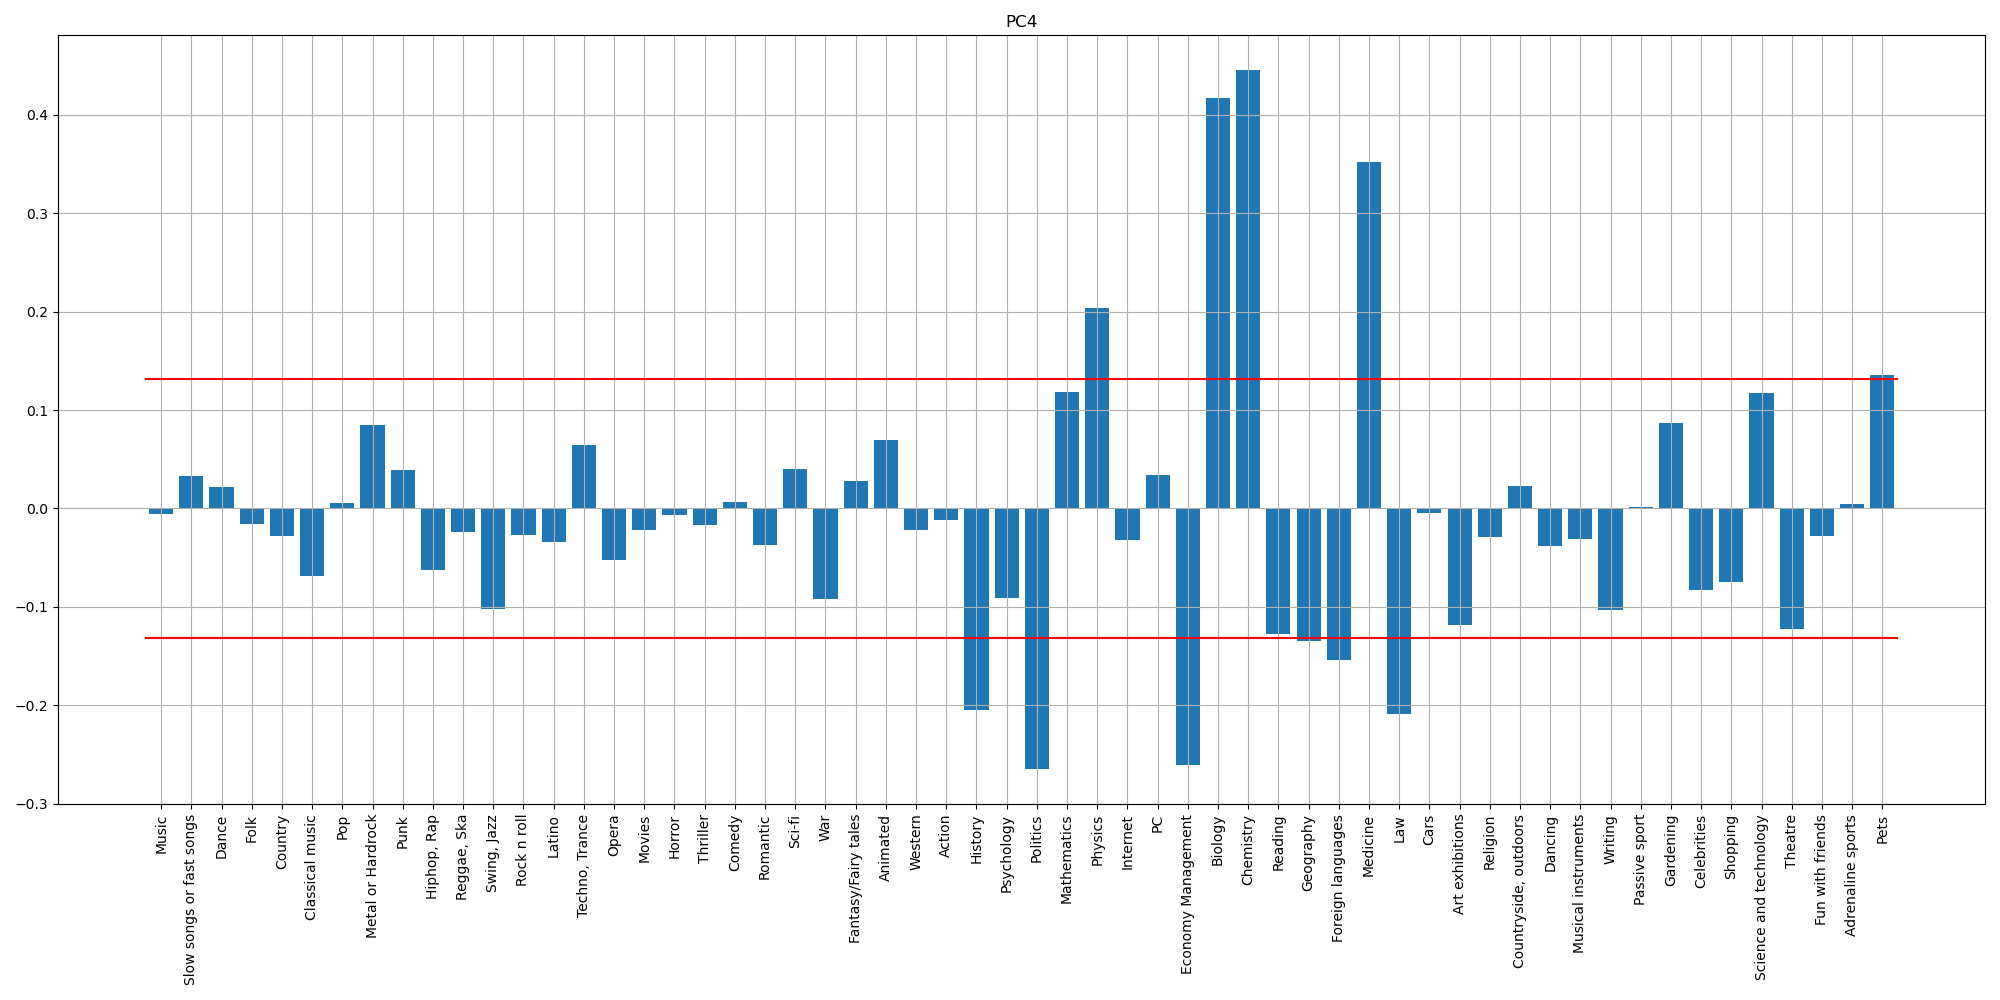


****************** PC4 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Physics', 'Biology', 'Chemistry', 'Medicine', 'Pets']

HIGH-VALUED NEGATIVE COMPONENTS: ['History', 'Politics', 'Economy Management', 'Geography', 'Foreign languages', 'Law']
*********************************************



In [106]:
# Definition of the parameter epsilon 
eps = np.sqrt(1 / pca.n_features_)

entertainments=workdf_1.keys()

# Plot of the barplots of the m=4 Princpal Components
for ii in range(m):
    
    plt.figure(figsize=(20,10))
    plt.bar(np.arange(pca.n_features_), pca.components_[ii, :]) 
    # Plot the red line of the threshold
    plt.plot([-0.5, pca.n_features_ - 0.5], [eps, eps], 'red')
    plt.plot([-0.5, pca.n_features_ - 0.5], [-eps, -eps], 'red')

    plt.xticks(ticks=np.arange(pca.n_features_),
               labels = entertainments,
               rotation=90)
    plt.title(f'PC{ii + 1}')

    plt.grid()
    plt.tight_layout()
    plt.show()
    
    ind_great_pos_PCii = np.argwhere(pca.components_[ii, :] >= eps).flatten()
    ind_great_neg_PCii = np.argwhere(pca.components_[ii, :] <= -eps).flatten()
    
    great_pos_PCii = [entertainments[i] for i in ind_great_pos_PCii]
    great_neg_PCii = [entertainments[i] for i in ind_great_neg_PCii]
    
    print('')
    print(f'****************** PC{ii+1} **********************')
    print(f'HIGH-VALUED POSITIVE COMPONENTS: {great_pos_PCii}')
    print('')
    print(f'HIGH-VALUED NEGATIVE COMPONENTS: {great_neg_PCii}')
    print('*********************************************')
    print('')

We now need to label the PCs based on their content. We are going to name them by looking at which **features** are the more positive and which are more negative. 

1. **PC1 = Culture and Arts (+)**: the most positive features in this PC are linked to the wolrd of *culture and arts* (*'Reading'*, *'Art exhibitions'*, *'Musical instruments'*, *'Theater'*). No negative features are particularly relevant in this case (because they all lie below the threshold).

1. **PC2 = Romanticism (-) VS Technology (+)**: the most negative components are *'Shopping'*, and *'Romantic'*, here summarized as *Romanticism* for simplicity sake. While, the largest positive features are *'Science and technology'*, *'Sci-fi'*, *'Cars'* and *'PC'*, summarized as *Technology*.

1. **PC3 = Metal (-) VS Hip-Pop (+)**: this Principal Component represents the dicotomy between *'Metal'* music and *'Hip-Pop, Rap'* music. The name comes naturally.

1. **PC4 = Humanities (-) VS Science (+)**: in the negative components we have *humanities*, which contains social sciences such as *'Law'*, *'History'*, *'Politics'* and '*Economy management*'. The positive features are associated with *scientific subjects*, such as *'Physics'*, *'Biology'*, *'Chemistry'* and *'Medicine'*.

In [107]:
# LIST OF THE NAMES ASSIGNED TO THE THREE PCs
pc_names = ['Culture and Arts (+)',
           'Romanticism (-) VS Technology (+)',
           'Metal (-) VS Hip-Pop (+)',
           'Humanities (-) VS Science (+)'
           ]

We then plot the *score graph* with respect to the first three Principal Components, which now have some names, thanks to previous point. 

We see that our datacloud is quite uniformly distributed in the three PCs: this suggests that the pool of students that answered the survey was quite heterogeneus. 

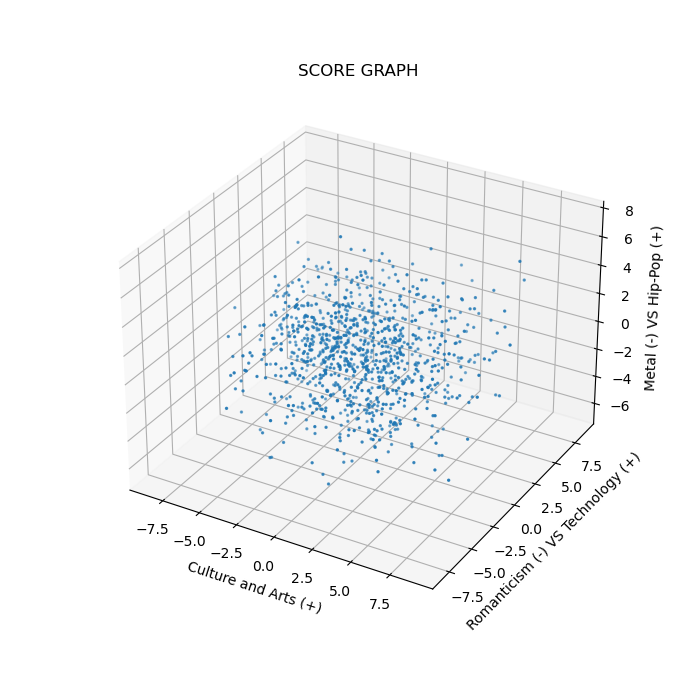

In [108]:
# Transforming the dataset in the 3-PC-space
Yentert= pca.transform(workdf_1)

# Plotting the score graph
sg_3d = plt.figure(figsize=(7, 7))
ax_sg_3d = sg_3d.add_subplot(111, projection='3d')
ax_sg_3d.scatter(Yentert[:, 0], Yentert[:, 1], Yentert[:, 2], s=2)

plt.title('SCORE GRAPH')
ax_sg_3d.set_xlabel(pc_names[0])
ax_sg_3d.set_ylabel(pc_names[1])
ax_sg_3d.set_zlabel(pc_names[2])
plt.grid()
plt.show()

### Exercise 5 (*k-means*)

Let's now apply the *k-means algorithm* to the dataframe *workdf_1* with respect to the PC-space. This algorithm compares the *silhouette coefficients* of different possible clusterings with $k$ clusters, for $k\in \{ 3, \dots, 10\}$. Then it chooses the one with the largest silhouette coefficient, allowing us to obtain the best number of clusters $k$. 

By running the code, we discover that the best number of clusters is $k = 5$. 

In [109]:
km_list = []
silcoeff_list = []
k_list = list(range(3, 11))

# Application of the k-means algorithm to Yentert
for i in range(len(k_list)):
    km_list.append(KMeans(n_clusters=k_list[i], n_init=3,random_state=rs))
    km = km_list[i]
    km.fit(Yentert)
    silcoeff_list.append(silhouette_score(Yentert, km.labels_))

# Finding the best k by comparing the silhouette coefficients
i_best = np.argmax(silcoeff_list)
k = k_list[i_best]
km = km_list[i_best]

# Visualizing the results
print('')
print('')
print('****************** RESULTS OF THE SEARCH... ******************')
print(f'BEST SILHOUETTE SCORE: {np.max(silcoeff_list)} --> k = {k}')
print('**************************************************************')



****************** RESULTS OF THE SEARCH... ******************
BEST SILHOUETTE SCORE: 0.2148482784604463 --> k = 5
**************************************************************


### k-Means parameters study

Regarding the *k-means parameters*, we have modified the *max_iter* input value in order to see whether or not it would change the resulting best $k$. 

Fixing the tolerance as its default value in the *k-means*, i.e. $\text{tol}=0.0001$, we can see the dependence of the best $k$ with respect to the maximum number of iterations.

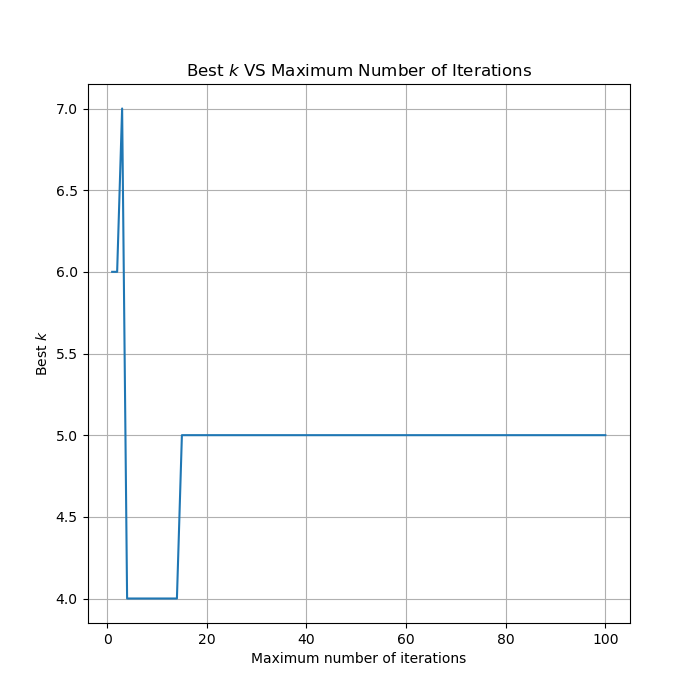

In [110]:
best_k1 = np.zeros([100,1])
for currente_max_iter in range(1,101):

    km1_list = []
    silcoeff_list1 = []
    k1_list = list(range(3, 11))

    for i in range(len(k1_list)):
        km1_list.append(KMeans(n_clusters=k1_list[i], n_init=3 , max_iter=currente_max_iter ,random_state=rs))
        km1 = km1_list[i]
        km1.fit(Yentert)
        silcoeff_list1.append(silhouette_score(Yentert, km1.labels_))

    # Finding the best k by looking at the silhouette coefficients
    i1_best = np.argmax(silcoeff_list1)
    k1 = k1_list[i1_best]
    km1 = km1_list[i1_best]

    best_k1[currente_max_iter-1] = k1

k_study1 = plt.figure(figsize=(7, 7))
plt.plot(range(1,101), best_k1)
plt.grid()
plt.title('Best $k$ VS Maximum Number of Iterations')
plt.xlabel('Maximum number of iterations')
plt.ylabel('Best $k$')
plt.show()


As a result, we see that we need at least $20$ iterates to have the convergence to $k=5$ of the *k-means* algorithm.

We now consider the effect of changing the tolerance, fixing the maximum number of iteration for instance at $25$. We see that the choice of the tolerance does not influence at all the best $k$. The best $k$ is stable to the value which we can expect from the previous graph.

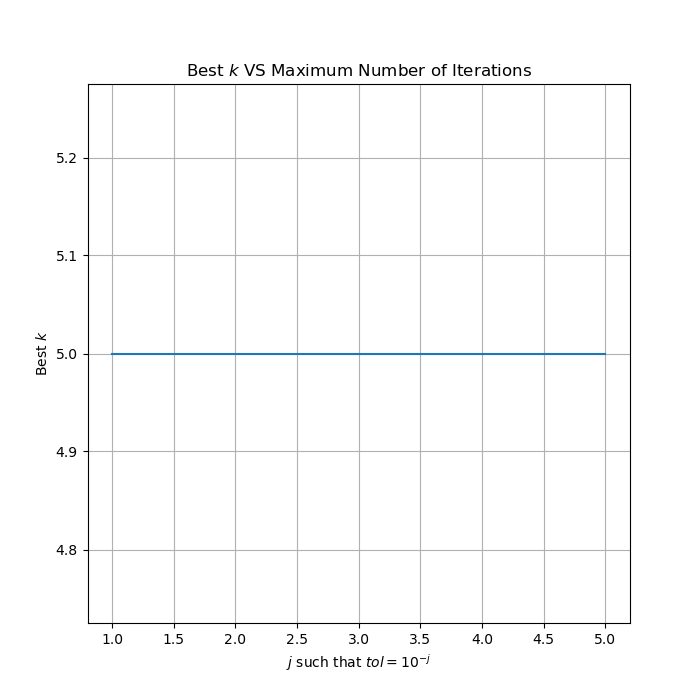

In [111]:
best_k2 = np.zeros([5,1])
for toll_iter in range(1,6):

    km2_list = []
    silcoeff_list2 = []
    k2_list = list(range(3, 11))

    for i in range(len(k2_list)):
        km2_list.append(KMeans(n_clusters=k2_list[i], n_init=3 , max_iter=25 , tol=10^(-toll_iter) ,random_state=rs))
        km2 = km2_list[i]
        km2.fit(Yentert)
        silcoeff_list2.append(silhouette_score(Yentert, km2.labels_))

    i2_best = np.argmax(silcoeff_list2)
    k2 = k2_list[i2_best]
    km2 = km2_list[i2_best]

    best_k2[toll_iter-1] = k2

k_study2 = plt.figure(figsize=(7, 7))
plt.plot(range(1,6), best_k2)
plt.grid()
plt.title('Best $k$ VS Maximum Number of Iterations')
plt.xlabel('$j$ such that $ tol = 10^{-j}$')
plt.ylabel('Best $k$')
plt.show()


### Exercise 6 (Centroid interpretation and visualization)

The *k-means algorithm* computes also a *centroid* for each cluster, which represents a generic member of the group, with the key features of that cluster. In the following, we will give an interpretation of the centroids and a graphical visualization with a barplot.

We now plot, again, the score graph, but with the added informations on the clusters. In particular, we choose a different color and shape for the points of the different clusters, and we also highlight the respective centroids.

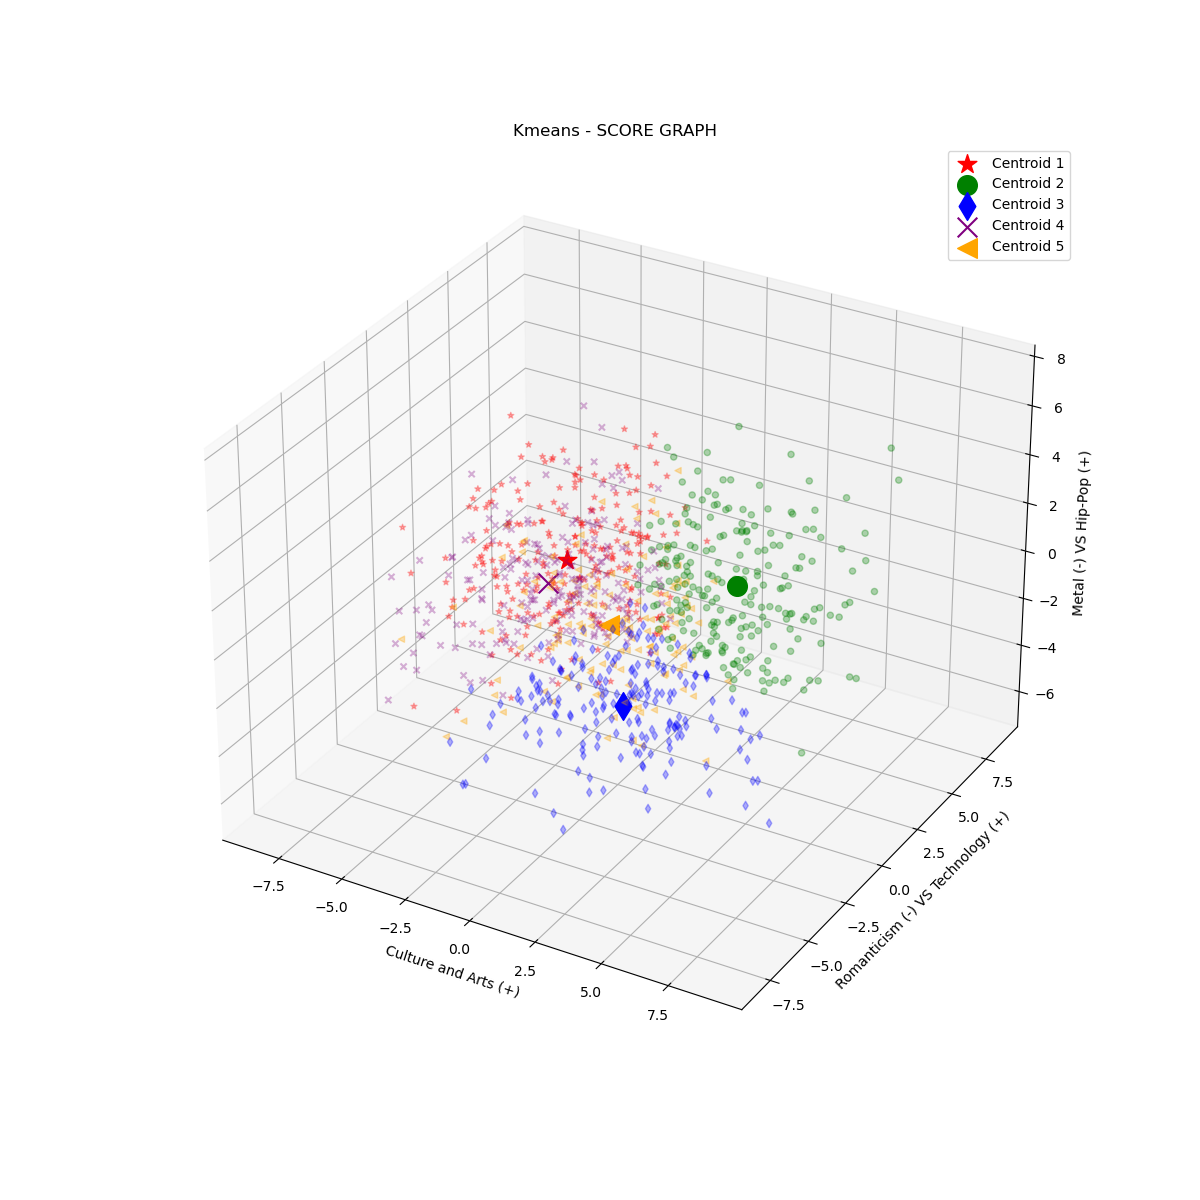

In [112]:
# Plotting the 3d score graph with the centroid

markers_dict = {0: '*', 1: 'o', 2: 'd', 3: 'x', 4: '<'}
color_dict = {0: 'red', 1: 'green', 2 : 'blue', 3: 'purple', 4: 'orange'}

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

ll = 0
ax.scatter(Yentert[km.labels_ == ll, 0], Yentert[km.labels_ == ll, 1], Yentert[km.labels_ == ll, 2], marker=markers_dict[ll], color = color_dict[ll], alpha = 0.3)
ll = 1
ax.scatter(Yentert[km.labels_ == ll, 0], Yentert[km.labels_ == ll, 1], Yentert[km.labels_ == ll, 2], marker=markers_dict[ll], color = color_dict[ll], alpha = 0.3)
ll = 2
ax.scatter(Yentert[km.labels_ == ll, 0], Yentert[km.labels_ == ll, 1], Yentert[km.labels_ == ll, 2], marker=markers_dict[ll], color = color_dict[ll], alpha = 0.3)
ll = 3
ax.scatter(Yentert[km.labels_ == ll, 0], Yentert[km.labels_ == ll, 1], Yentert[km.labels_ == ll, 2], marker=markers_dict[ll], color = color_dict[ll], alpha = 0.3)
ll = 4
ax.scatter(Yentert[km.labels_ == ll, 0], Yentert[km.labels_ == ll, 1], Yentert[km.labels_ == ll, 2], marker=markers_dict[ll], color = color_dict[ll], alpha = 0.3)

for ll in range(5):
    ax.scatter(km.cluster_centers_[ll, 0], km.cluster_centers_[ll, 1], km.cluster_centers_[ll, 2], 
        color = color_dict[ll], 
        marker= markers_dict[ll], 
        s = 200,
        label = f'Centroid {ll+1}', 
        alpha = 1)

plt.title('Kmeans - SCORE GRAPH')
ax.set_xlabel(pc_names[0])
ax.set_ylabel(pc_names[1])
ax.set_zlabel(pc_names[2])

plt.legend()
plt.grid()
plt.show()

We can graphically visualize the centroid's component with respect to the PCs by using the following barplot:

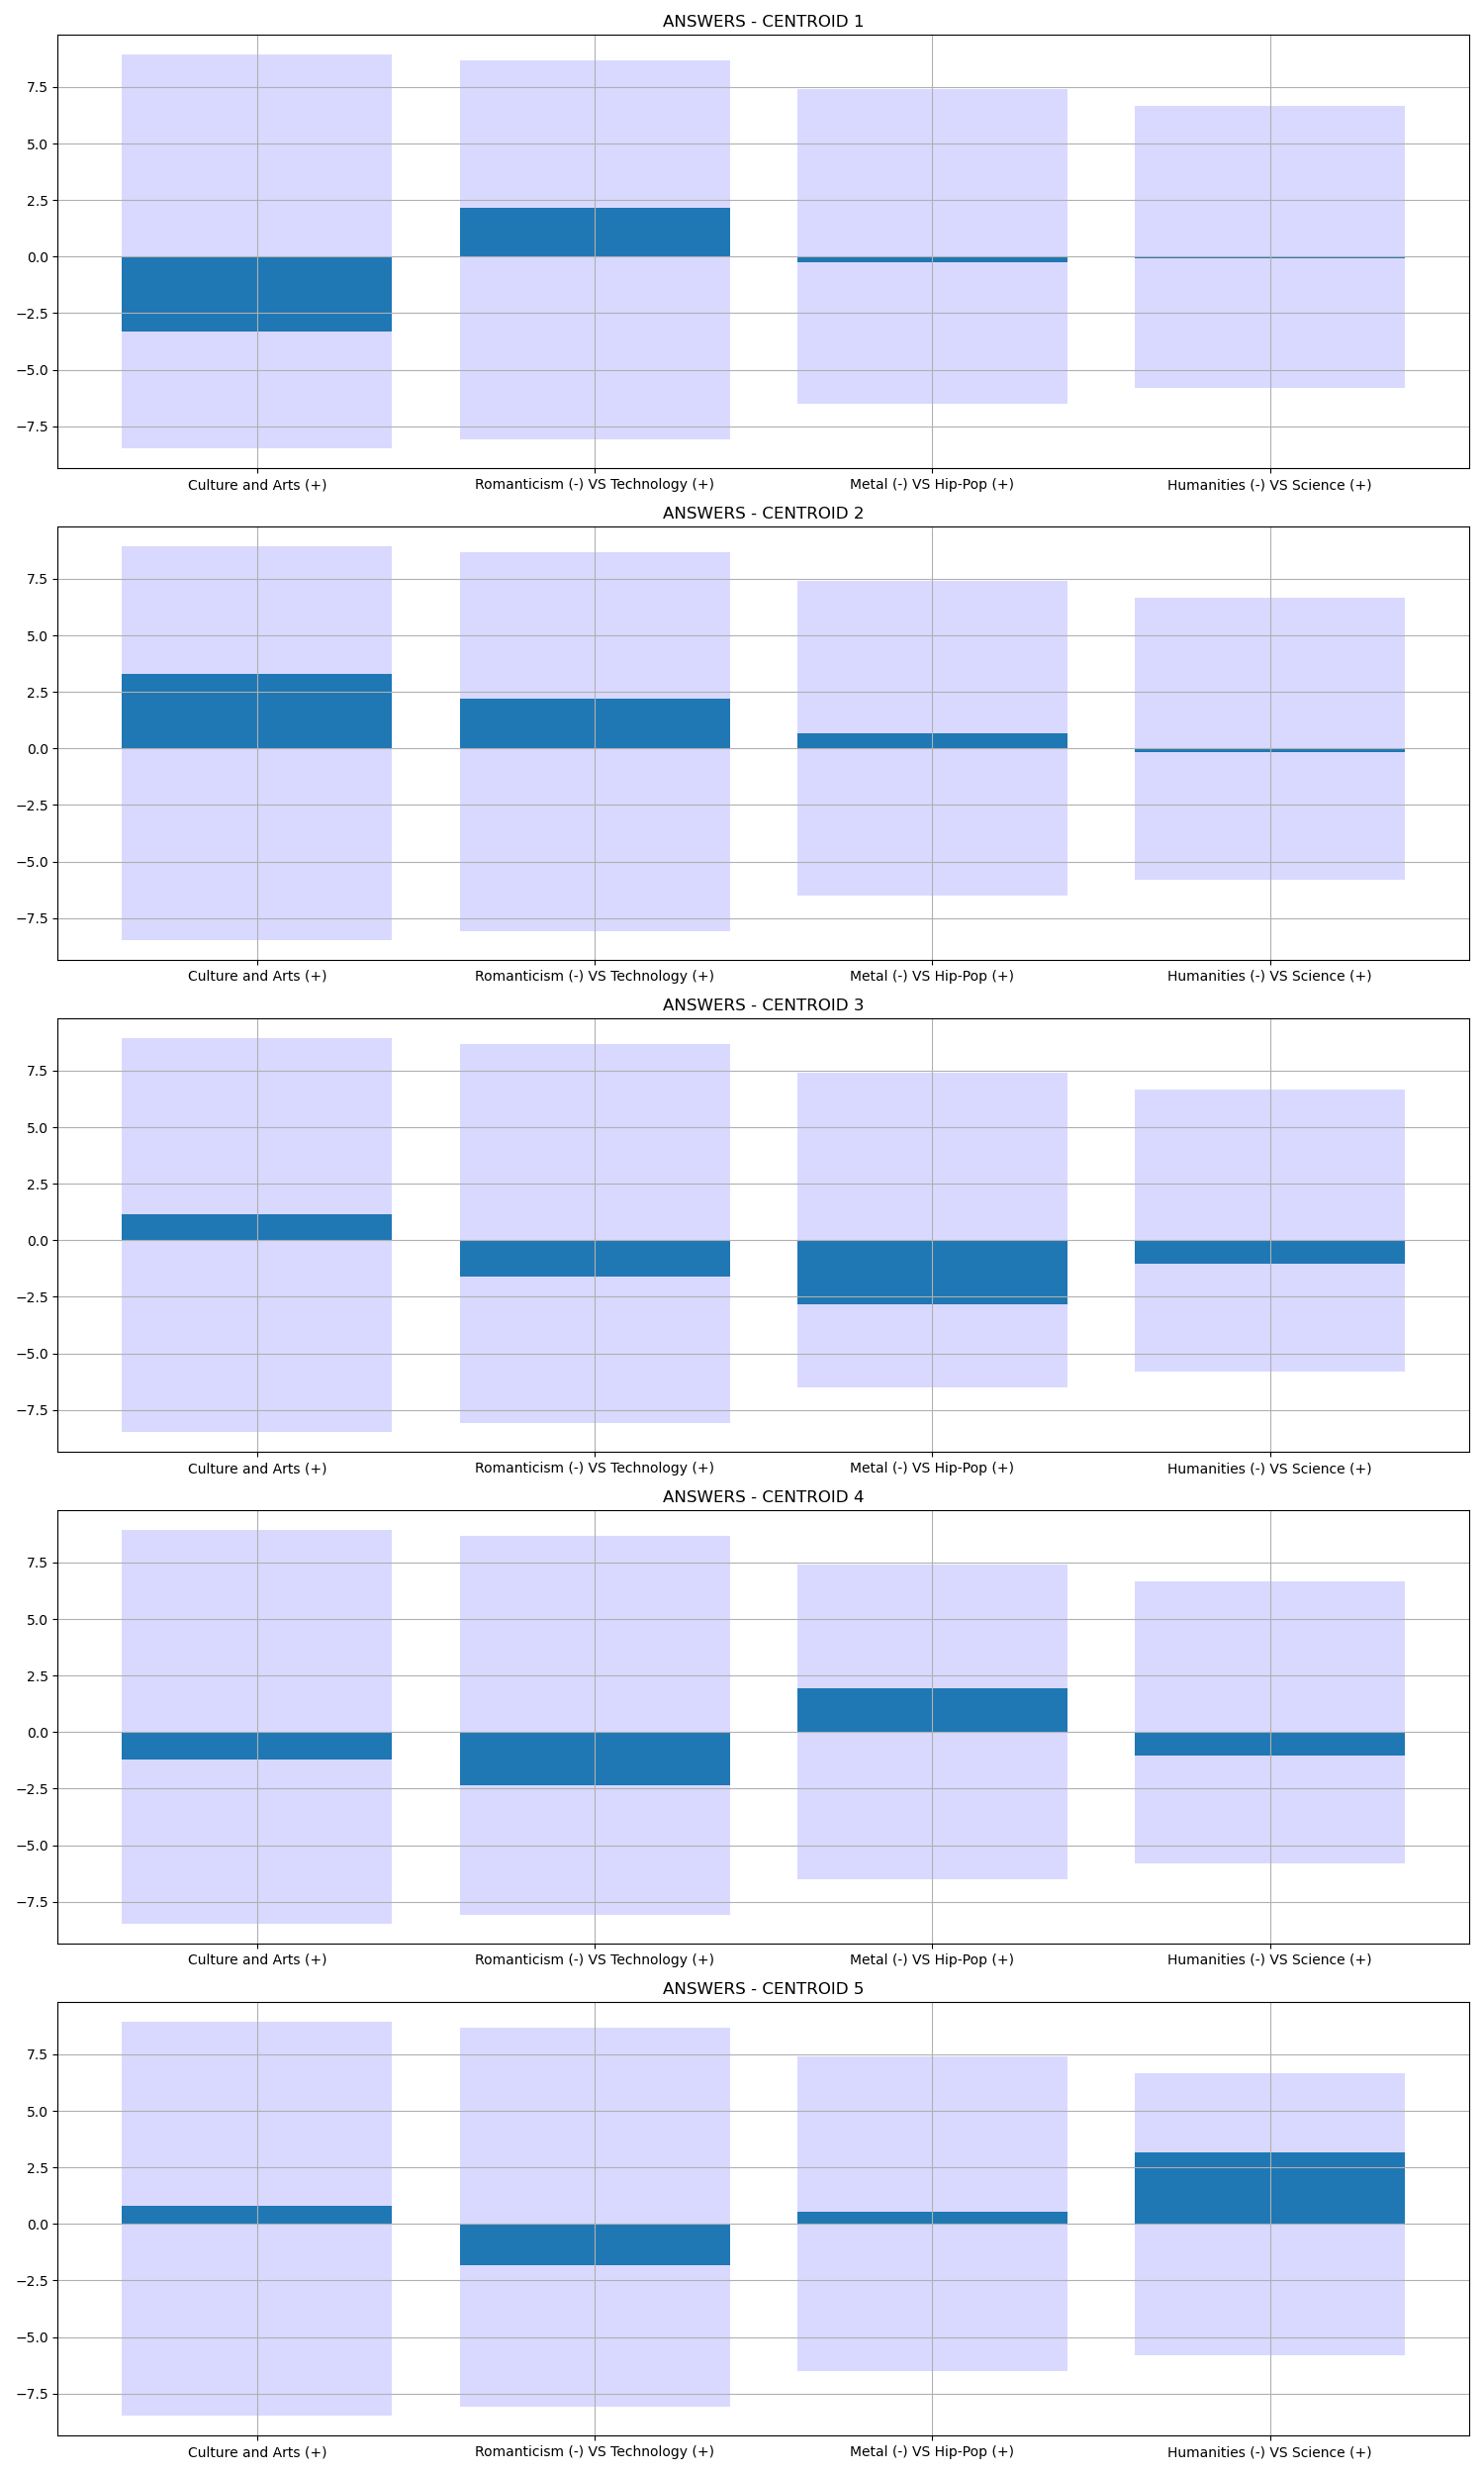

In [113]:
# Compute the min and max values of the point cloud in the PC-space
maxs_y = Yentert.max(axis=0) 
mins_y = Yentert.min(axis=0) 

# Plotting the barplot of the centroids
fig_centroids, ax_centroids = plt.subplots(5, 1, figsize=(15, 25))
for ii in range(k):
    ax_centroids[ii].bar(np.arange(km.cluster_centers_.shape[1]), maxs_y, color='blue', alpha=0.15)
    ax_centroids[ii].bar(np.arange(km.cluster_centers_.shape[1]), mins_y, color='blue', alpha=0.15)
    ax_centroids[ii].bar(np.arange(km.cluster_centers_.shape[1]), km.cluster_centers_[ii, :])
    ax_centroids[ii].set_xticks(ticks=np.arange(km.cluster_centers_.shape[1]))
    ax_centroids[ii].set_xticklabels(labels=pc_names, rotation=0)
    ax_centroids[ii].grid(visible=True, which='both')
    plt.tight_layout()
    ax_centroids[ii].set_title(f'ANSWERS - CENTROID {ii+1}')

Using the same reasoning of **Exercise 4**, we can give names to the centroids by looking directly at their predominant features. Here we have summarized the names of the centroids:

1. The first centroid is characterized by being very *technological* (so with high features in *'Technology'*, *'PC'*, *'Cars'*, ...) but very little *romantic* and not interested at all in *culture and arts*. So we decided to name it *"Pragmatic student"*.

1. The second centroid is very similar to the first one but it has an high positive component in *Culture and Arts*. We decided to name it *"Cultured student"*.

1. The third centroid presents as the most expressed feature the love for *Metal music*, but it is also *Romantic* and loves *Social Science and Culture*. We decided to name it *"Metalhead student"* for simplicity.

1. The fourth centroid describes a very romantic person with the passion for Hip-Pop music. Thus, we named it *"Romantic Hip-Pop enjoyer"*.

1. The last centroid depicts a type person that is passionate of Science, so we ultimately named it *"Science passionate"*.

In [114]:
# LIST OF THE NAMES ASSIGNED TO THE CENTROIDS
centroids_names = ['Pragmatic student',
           'Cultured student',
           'Metalhead student',
           'Romantic Hip-Pop enjoyer',
           'Science passionate'
           ]

### Exercise 7 - Optional (External Evaluation)
In this section, we perform some external evaluations of the clusters, in order to better understand how students with different demographic features are distributed among the 5 clusters. 
In particular we have decided to apply an external evaluation for only two demographic features: *'Gender'* and the *'Home Town Type'*. 
We thought that these two features were the most interesting to analyse in a set of students of an University, since the *gender* could affect the personality traits and the type of city could also affect a person's tastes and preferences. 

From our point of view, some answers in the dataset are not very informative (generally speaking) of the demographic distributions in the clusters, such as being left- or right-handed. 
At the same time, there are other answers that, in this particular case, are not relevant for a set of students. For instance, the age is approximately the same since they are all near the $20$'s.

There are also some questions, such as the *'Height'* and *'Weight'*, that are closely related to the gender, and so we decided not to study them individually.

Let's consider the *male and female* distributions in the full dataset *workdf_1*.

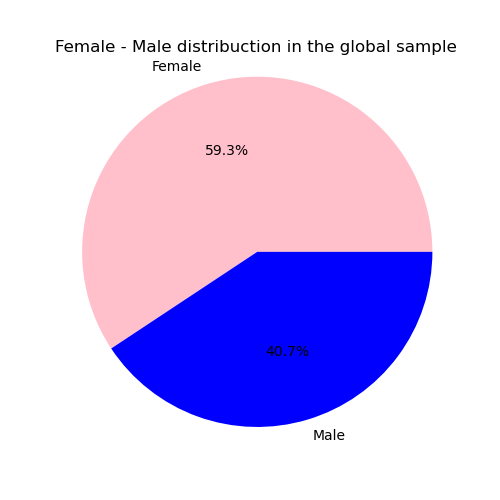

In [115]:
nf_tot = len([t for t in demography_df['Gender'].values if t == 'female'])
nm_tot = len(demography_df) - nf_tot

fig_pie1, ax_pie1 =plt.subplots(figsize=(5,5))
plt.title('Female - Male distribuction in the global sample')
plt.pie([nf_tot, nm_tot], autopct='%1.1f%%', labels =['Female','Male'],colors=['pink','blue'])
ax_pie1.axis('equal')
plt.show()

We can see from the *pie chart* that the majority of students that answered the survey are female $(59.3\%)$.

Then, we have computed the distibutions of male and female in the 5 clusters. Taking into account the global distribution of males and females, we find that:


1. The large majority of pragmatic students are males.

1. The students that are interested in culture and arts are evenly distributed between the two genders.

1. The majority of metal or Hip-Pop enjoyers are females.

1. Again, most of the science passionates are females but more evenly distributed than the two previous musical features.

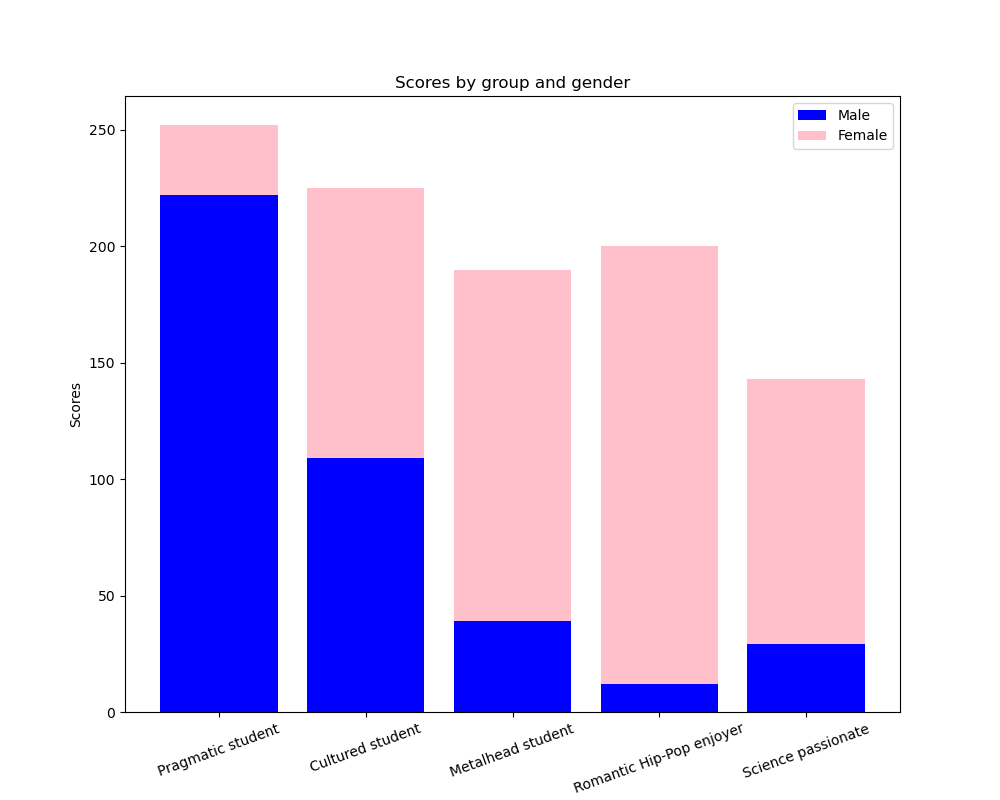

In [116]:
nf = np.zeros(k)
nm = np.zeros(k)

for kk in range(k):
    for ii in range(len(km.labels_)):
        if kk == km.labels_[ii]:
            if demography_df['Gender'].values[ii] == 'female':
                nf[kk] += 1
            else:
                nm[kk] += 1

# THE BARPLOT

fig_mf, ax_mf = plt.subplots(figsize=(10, 8))
ax_mf.bar(centroids_names, nm, label='Male',color='blue')
ax_mf.bar(centroids_names, nf, bottom=nm,
       label='Female',color='pink')
plt.xticks(rotation=20)
ax_mf.set_ylabel('Scores')
ax_mf.set_title('Scores by group and gender')
ax_mf.legend()

plt.show()

Let's now study the demographic feature called *'Home Town Type'*, which contains only two possible answers: *city* and *village*.
By a direct inspection of the distribution of these feature in the dataset *workdf_1*, we can see that $\simeq 70 \%$ of students lives in a city,  while the remaing $\simeq 30 \%$ lives in a village.

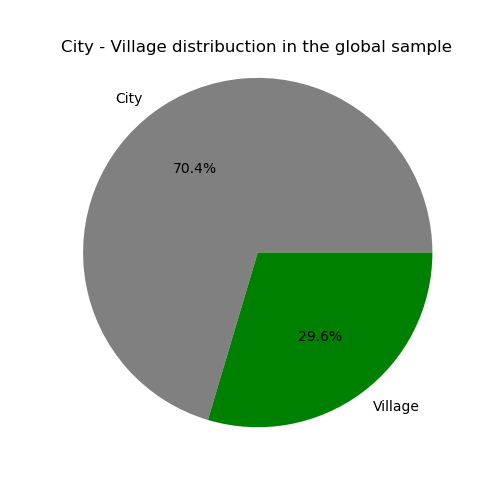

In [117]:
city_tot  = len([t for t in demography_df['Home Town Type'].values if t == 'city'])
vil_tot = len(demography_df) - city_tot

fig_pie1, ax_pie1 =plt.subplots(figsize = (5,5))
plt.title('City - Village distribuction in the global sample')
plt.pie([city_tot, vil_tot], autopct='%1.1f%%', labels =['City','Village'],colors=['grey','green'])
ax_pie1.axis('equal')
plt.show()

Now, if we compute the distribution of the feature in the 5 cluster, we can see that they are approximately always in a $70\% - 30\%$ relations. This means that, against our initial guess, this demographical feature does not give any interesting information on the cluster internal distrubutions. 

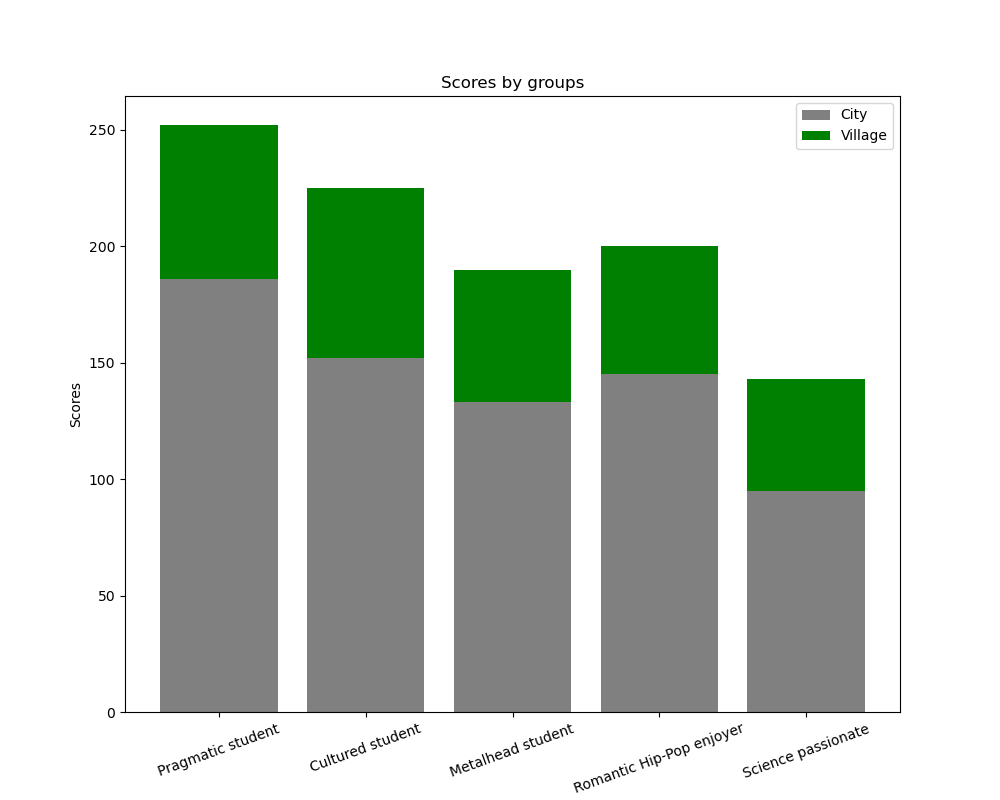

In [118]:
ncity = np.zeros(k)
nvil = np.zeros(k)

for kk in range(k):
    for ii in range(len(km.labels_)):
        if kk == km.labels_[ii]:
            if demography_df['Home Town Type'].values[ii] == 'city':
                ncity[kk] += 1
            else:
                nvil[kk] += 1

# THE BARPLOT

fig_cv, ax_cv = plt.subplots(figsize=(10,8))
ax_cv.bar(centroids_names, ncity, label='City',color='grey')   
ax_cv.bar(centroids_names, nvil, bottom=ncity,label='Village',color='green') 
plt.xticks(rotation=20)
ax_cv.set_ylabel('Scores')
ax_cv.set_title('Scores by groups')
ax_cv.legend()

plt.show()

 ### Exercise 8 (Computation of the PCs)
 We now apply the same procedure that we used for studying the dataframe *workdf_1* for the larger dataframe *workdf_tot*, which contains both enterteinment and personality questions.

 We start by using the Principal Component Analysis on the new dataframe *workdf_tot*. By appling it, we see that even using $6$ PCs, we have only explained $27\%$ of the total variance. So we choose $m = 6$.

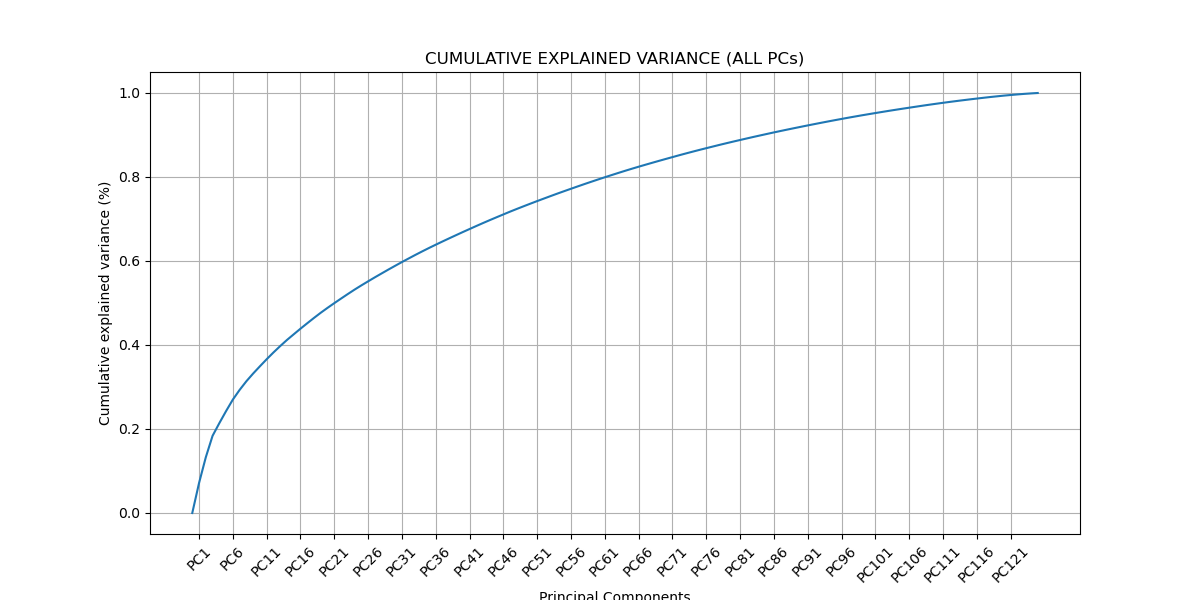

First 6 principal components explained variance: [0.07128763 0.1326825  0.18376982 0.21389629 0.24272964 0.27007046]


In [119]:
# Computing m
pca_full = PCA() 
pca_full.fit(workdf_tot.values) 


plt.figure(figsize=(12, 6))
plt.plot(np.insert(np.cumsum(pca_full.explained_variance_ratio_), 0, 0))
plt.title('CUMULATIVE EXPLAINED VARIANCE (ALL PCs)')
plt.xticks(ticks=np.arange(1, pca_full.n_features_ + 1, 5), 
           labels=[f'PC{i}' for i in range(1, pca_full.n_features_ + 1, 5)],
           rotation=45)
plt.xlabel('Principal Components')
plt.ylabel('Cumulative explained variance (%)')
plt.grid()
plt.show()

print('First 6 principal components explained variance:' ,np.cumsum(pca_full.explained_variance_ratio_)[:6])
m = 6

We then plot the *curve of cumulative percentage of explained variance* and the *barplot of the percentage explained* by the 6 Principal Components.

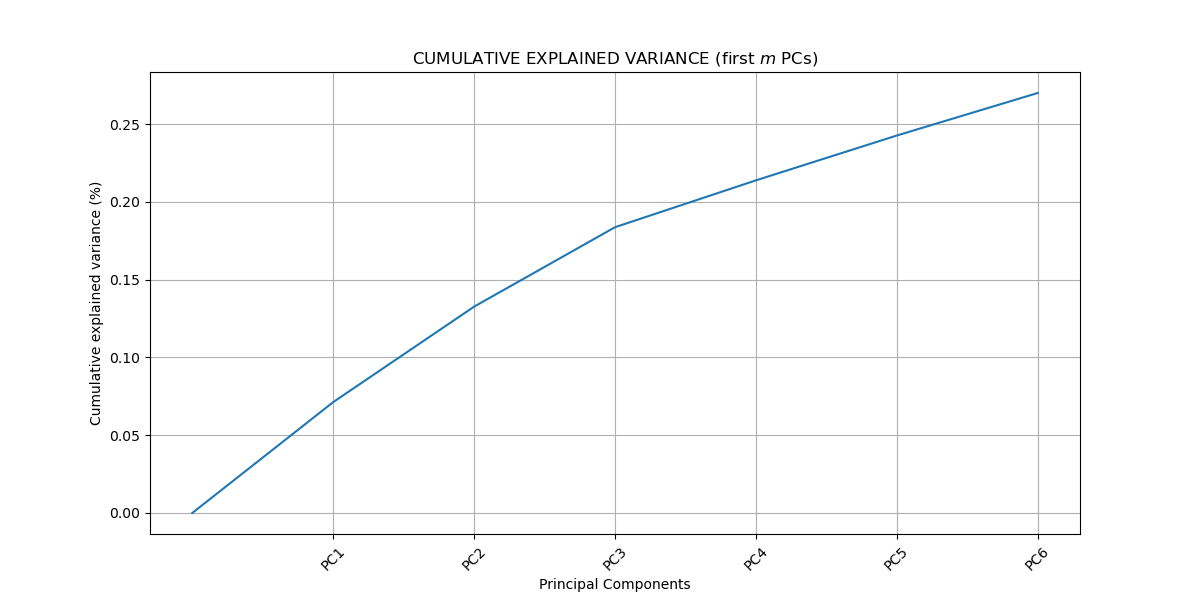

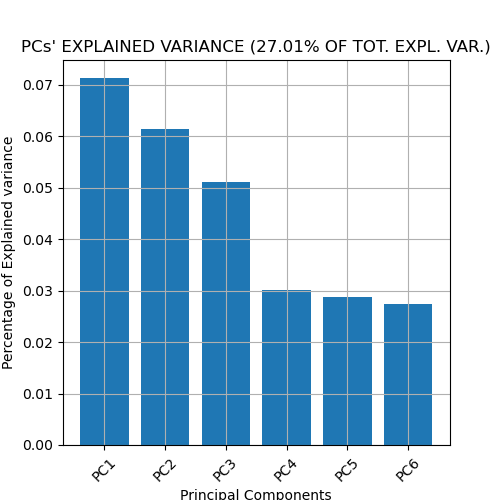

In [120]:

pca = PCA(n_components=m)

pca.fit(workdf_tot.values)

round_expl_var_ratio = np.round(pca.explained_variance_ratio_.sum() * 100, decimals=2)

# The curve of cumulative total variance expained
plt.figure(figsize=(12, 6))
plt.plot(np.insert(np.cumsum(pca.explained_variance_ratio_), 0, 0))
plt.title('CUMULATIVE EXPLAINED VARIANCE (first $m$ PCs)')
plt.xticks(ticks=np.arange(1, m + 1), 
           labels=[f'PC{i}' for i in range(1, m+ 1)],
           rotation=45)
plt.xlabel('Principal Components')
plt.ylabel('Cumulative explained variance (%)')
plt.grid()
plt.show()

# Plotting teh barplot
plt.figure(figsize=(5, 5))
plt.bar(range(1, m + 1), pca.explained_variance_ratio_)
plt.title(f"PCs' EXPLAINED VARIANCE ({round_expl_var_ratio}% OF TOT. EXPL. VAR.)")
plt.xticks(ticks=np.arange(1, m + 1), 
           labels=[f'PC{i}' for i in range(1, m + 1)],
           rotation=45)
plt.xlabel('Principal Components')
plt.ylabel('Percentage of Explained variance')
plt.grid()
plt.show()

### Exercise 9 (Interpretation of the PCs)
As before, we plot the barplot of the features expressions inside of the 6 Principal Components and we give them names based on the more expressed features.
Since there are more features than before, we decided to increase the threshold $\varepsilon$ in order to ease the interpretation. In particular, we used $\varepsilon = \sqrt{3/\#\text{features}}$.

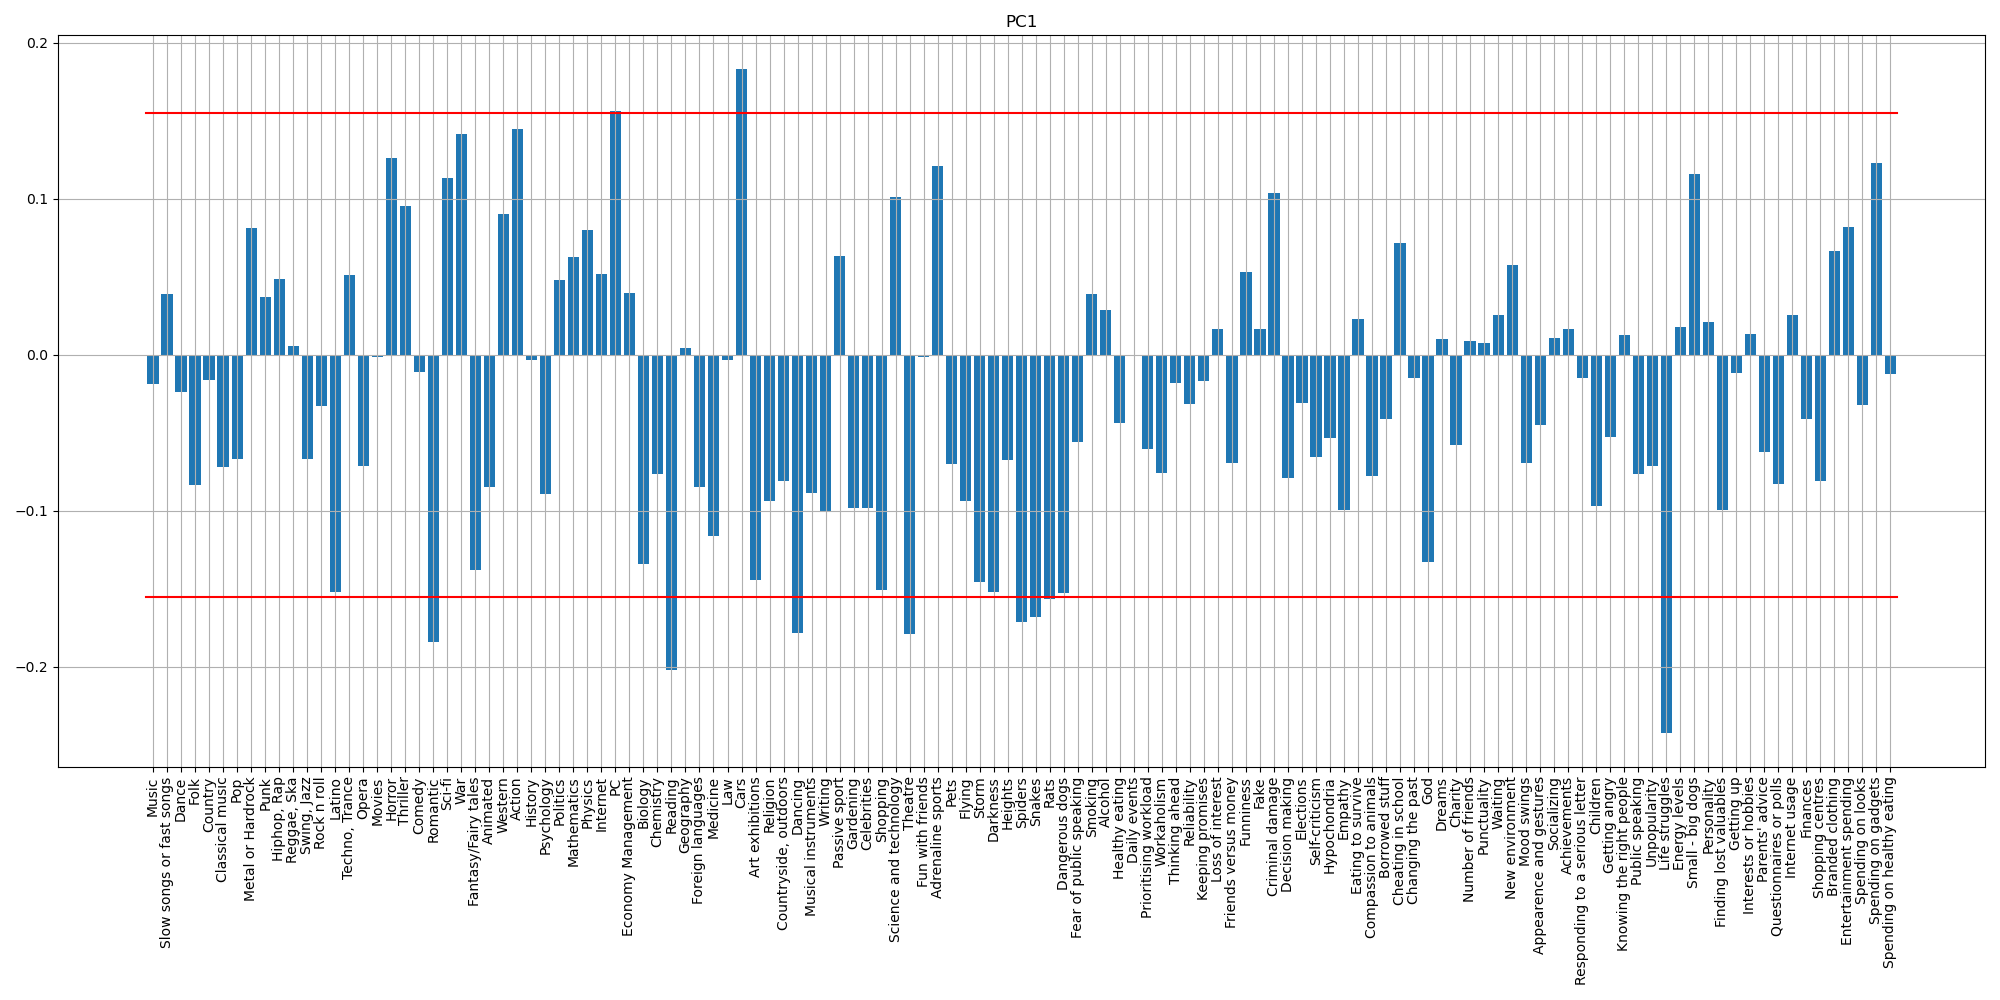


****************** PC1 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['PC', 'Cars']

HIGH-VALUED NEGATIVE COMPONENTS: ['Romantic', 'Reading', 'Dancing', 'Theatre', 'Spiders', 'Snakes', 'Rats', 'Life struggles']
*********************************************



<ipython-input-121-b29f1cf0af96>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


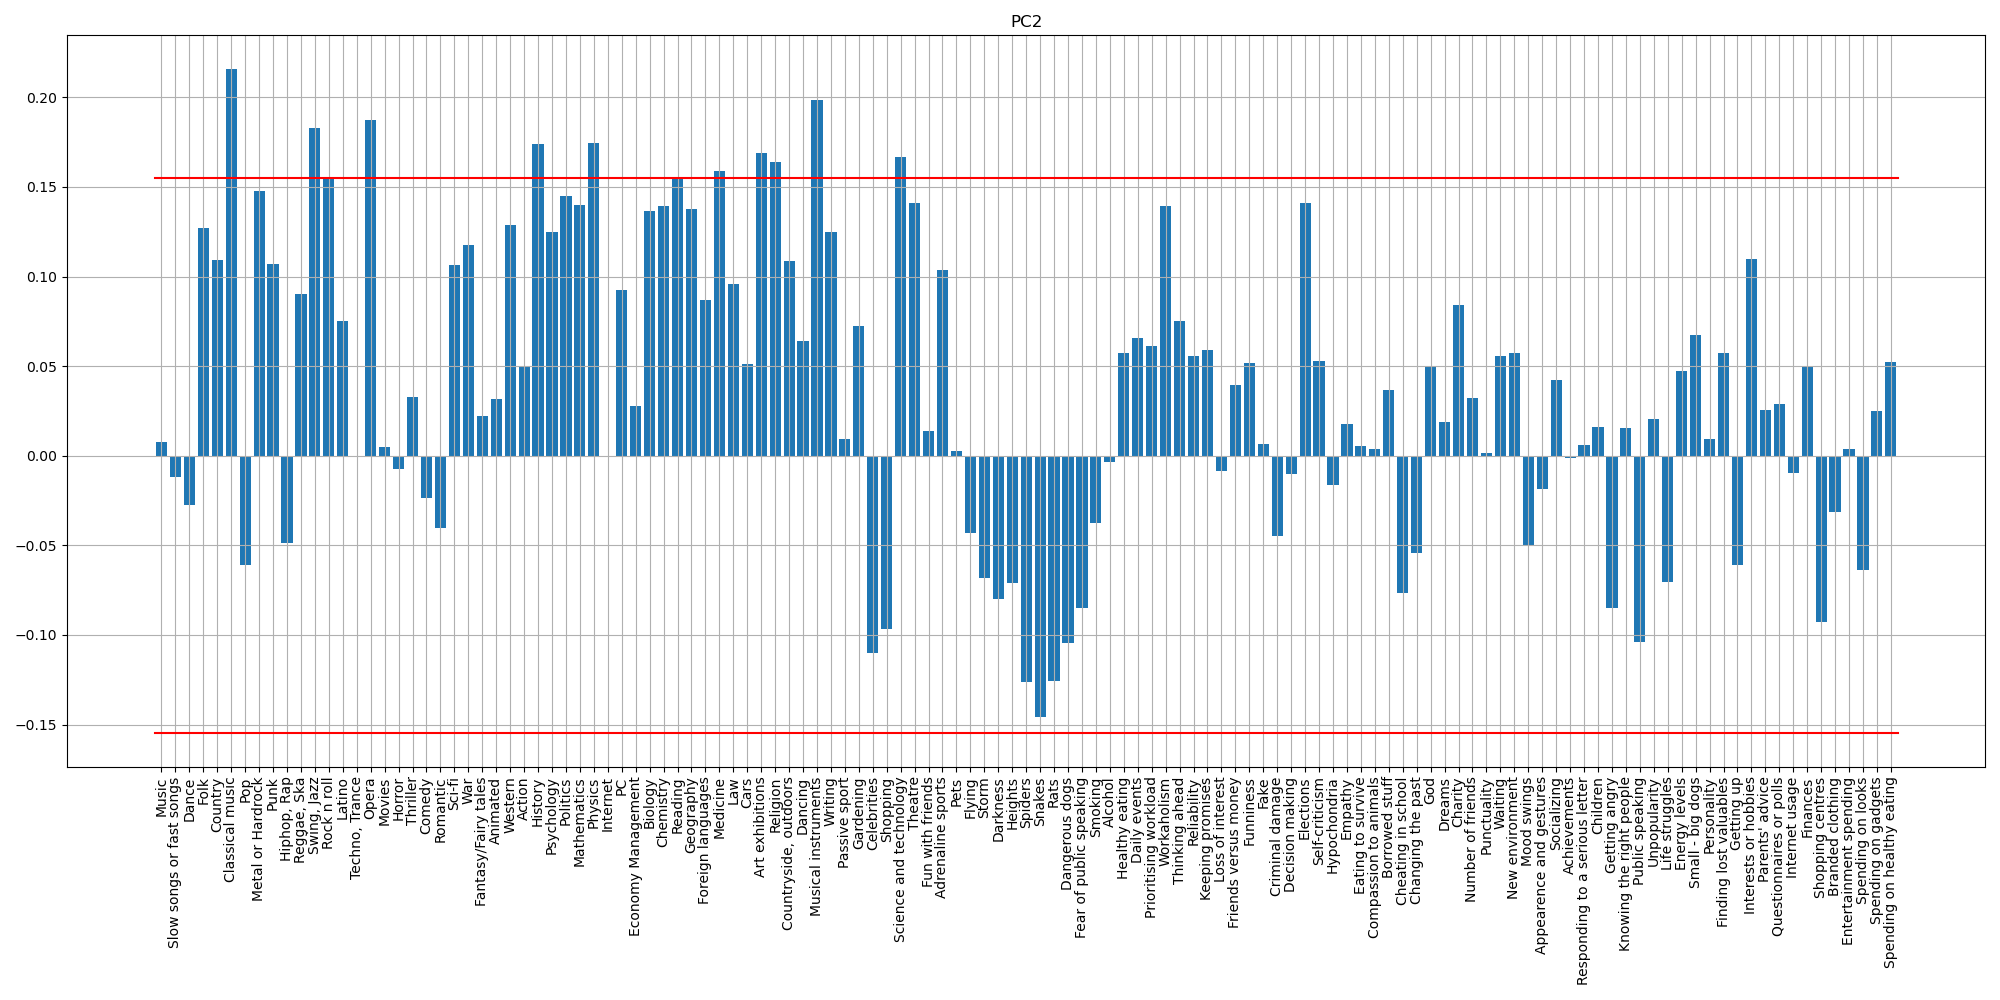


****************** PC2 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Classical music', 'Swing, Jazz', 'Rock n roll', 'Opera', 'History', 'Physics', 'Medicine', 'Art exhibitions', 'Religion', 'Musical instruments', 'Science and technology']

HIGH-VALUED NEGATIVE COMPONENTS: []
*********************************************



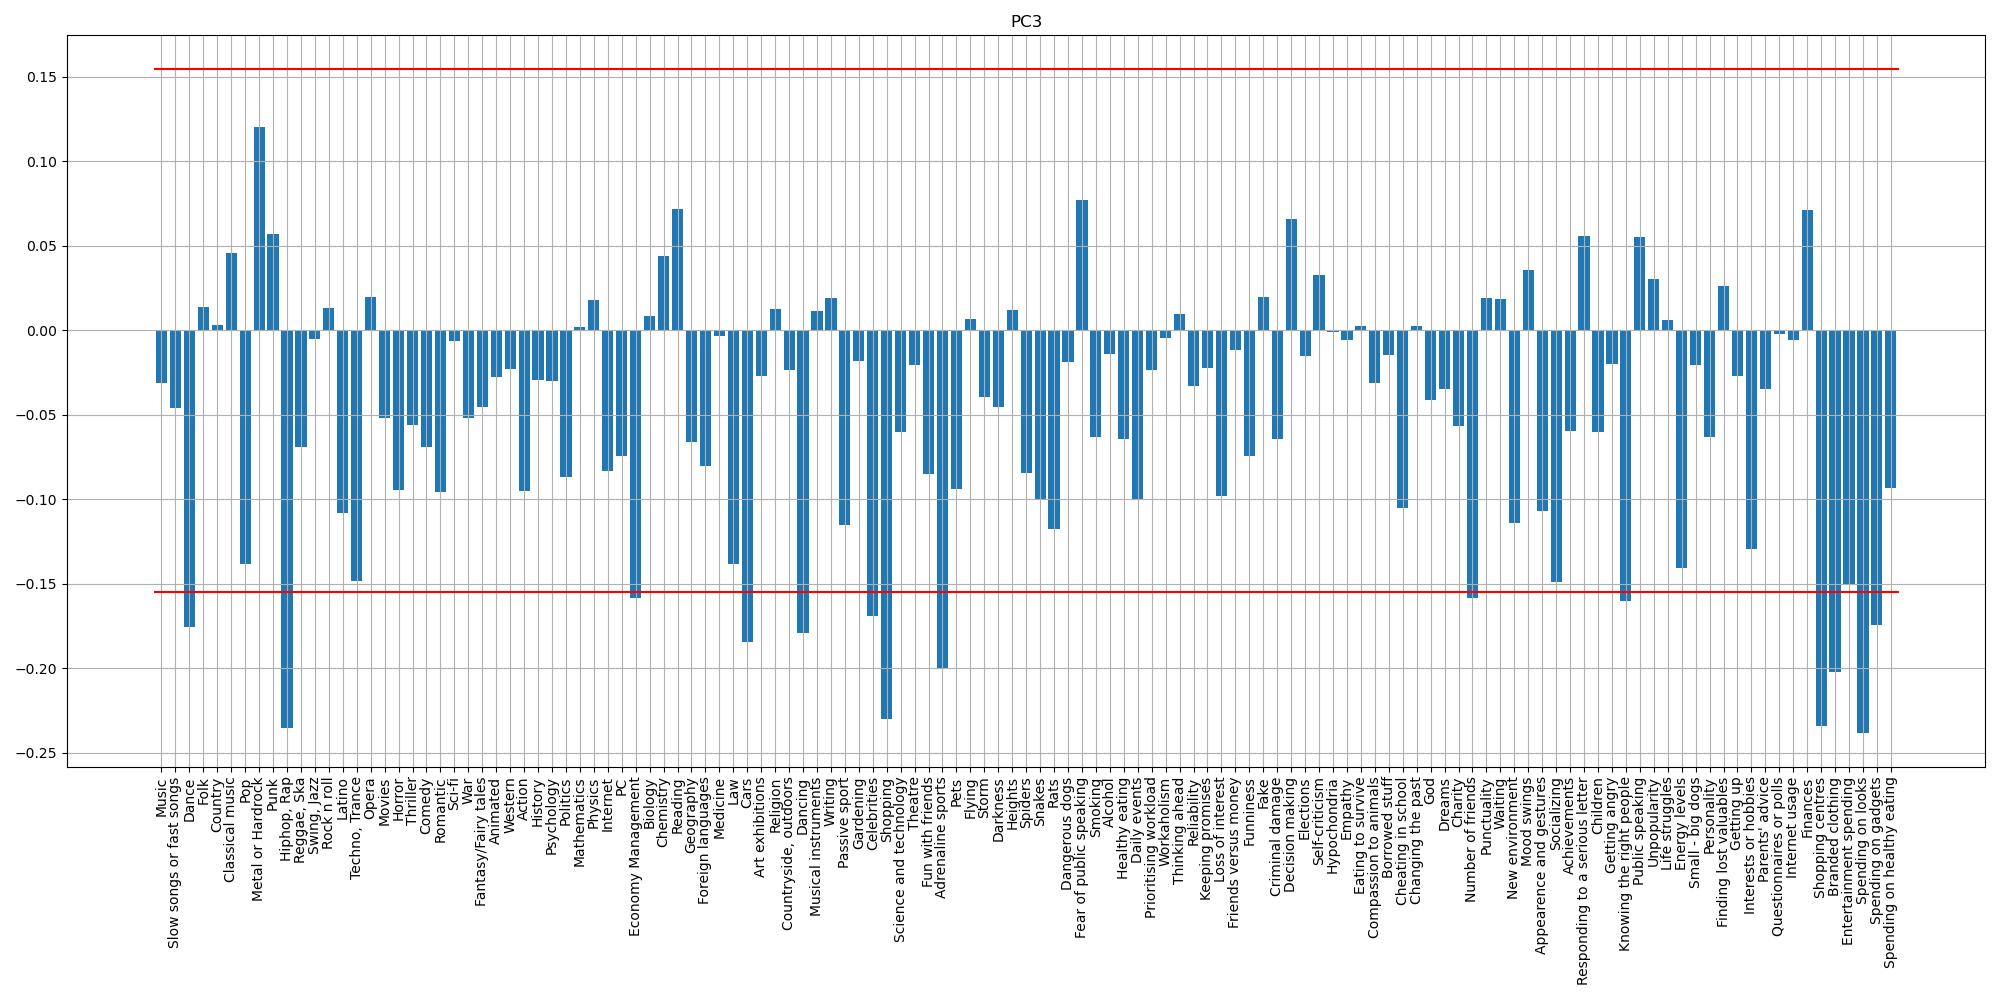


****************** PC3 **********************
HIGH-VALUED POSITIVE COMPONENTS: []

HIGH-VALUED NEGATIVE COMPONENTS: ['Dance', 'Hiphop, Rap', 'Economy Management', 'Cars', 'Dancing', 'Celebrities', 'Shopping', 'Adrenaline sports', 'Number of friends', 'Knowing the right people', 'Shopping centres', 'Branded clothing', 'Spending on looks', 'Spending on gadgets']
*********************************************



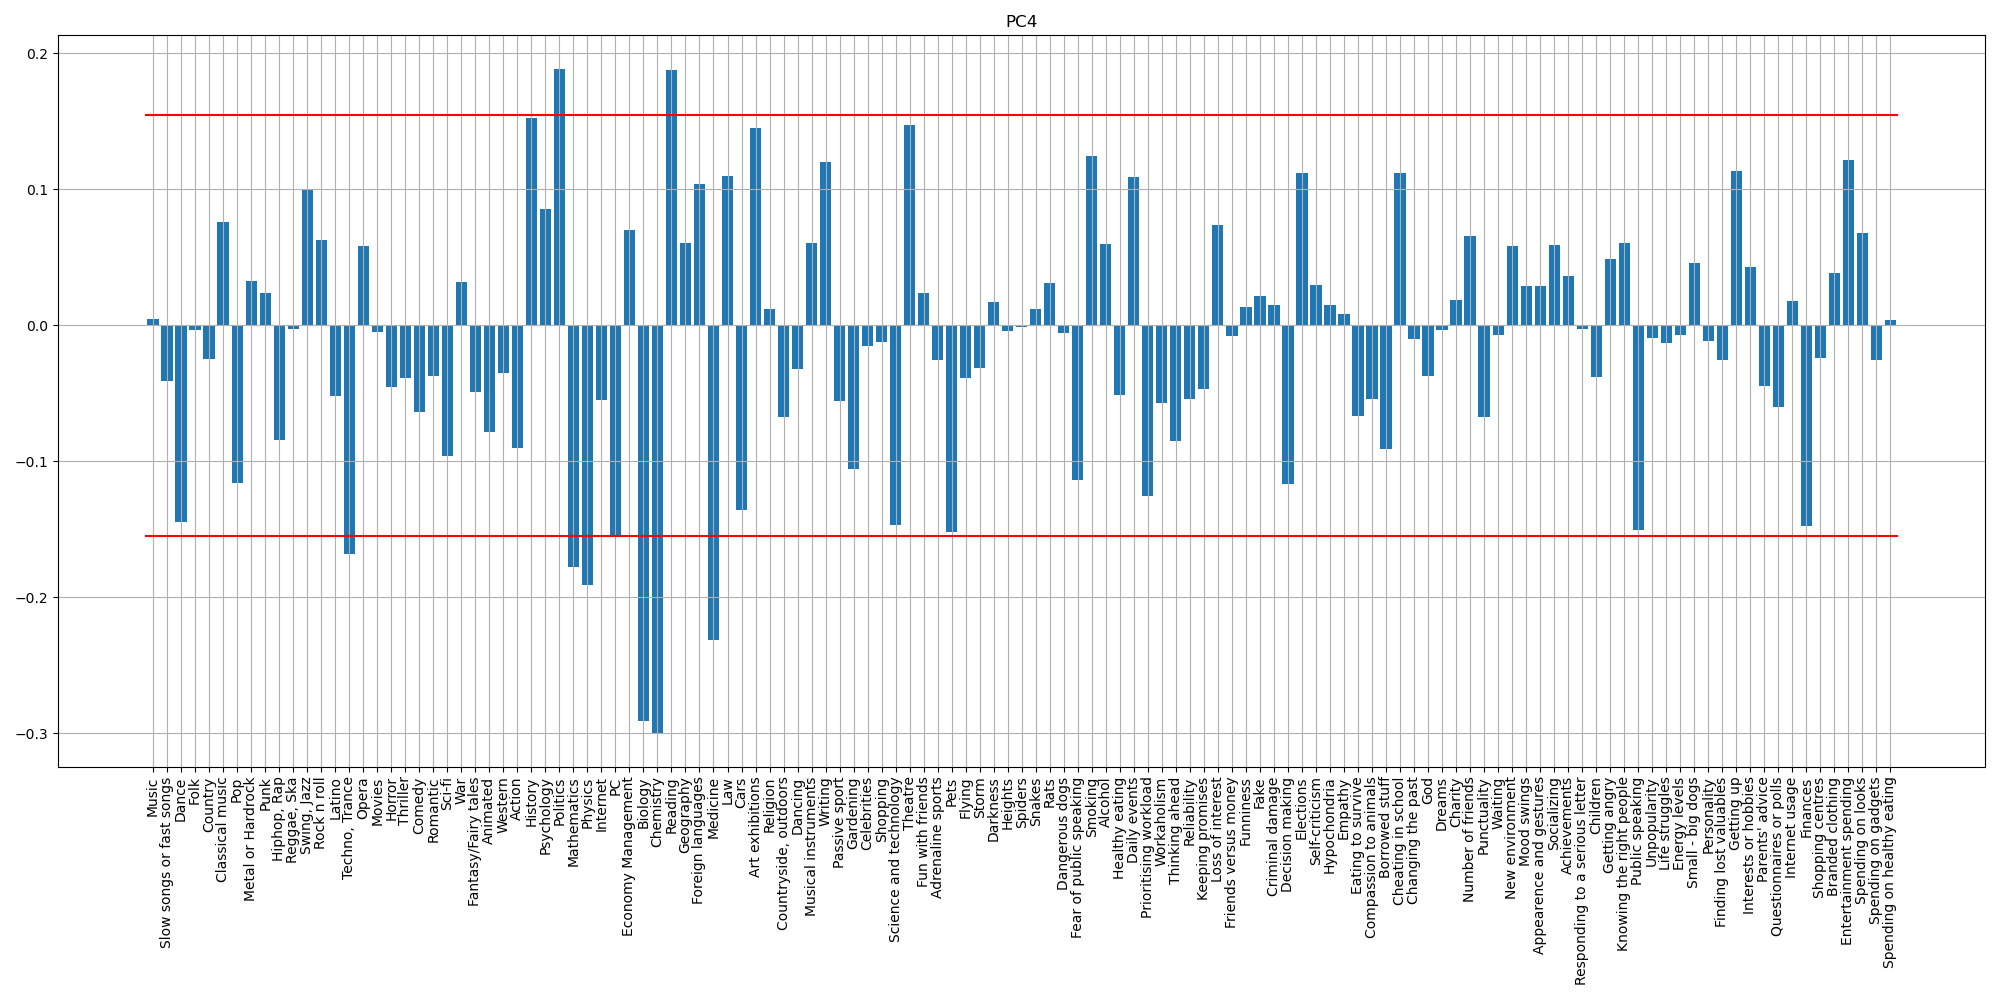


****************** PC4 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Politics', 'Reading']

HIGH-VALUED NEGATIVE COMPONENTS: ['Techno, Trance', 'Mathematics', 'Physics', 'Biology', 'Chemistry', 'Medicine']
*********************************************



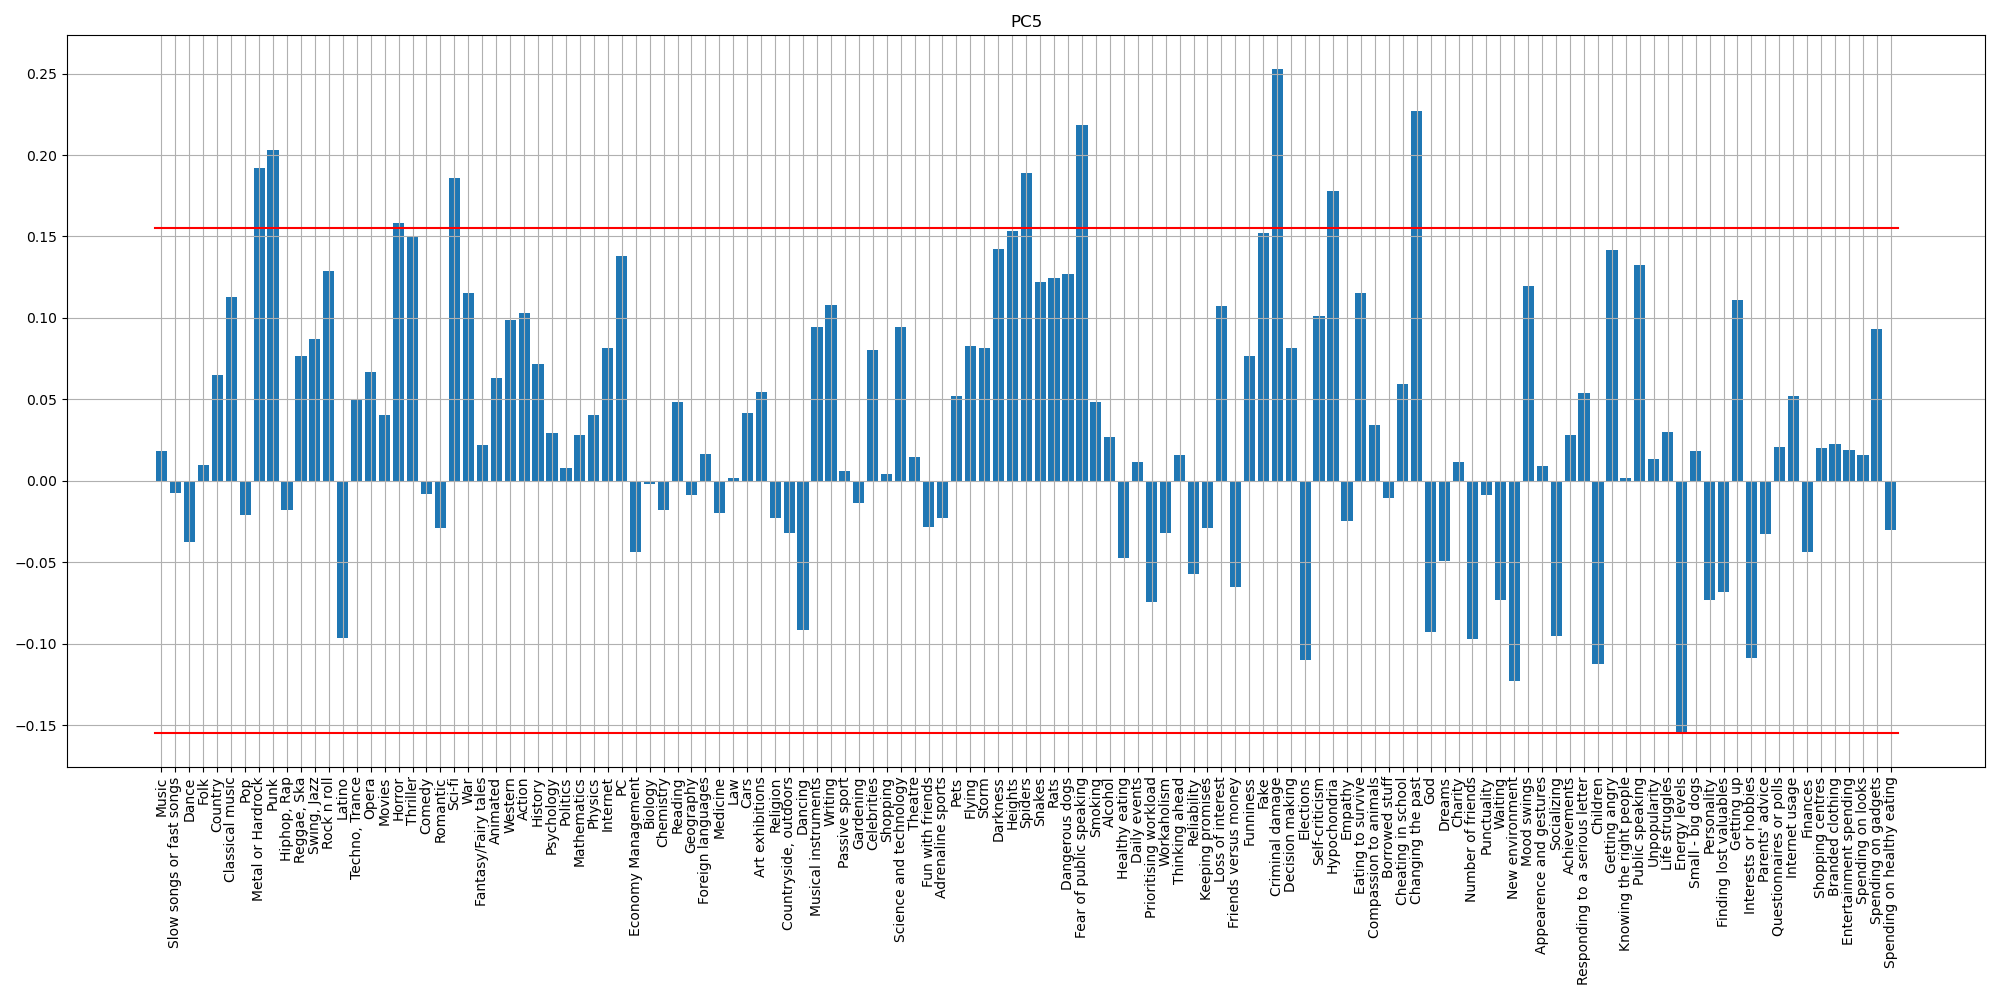


****************** PC5 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Metal or Hardrock', 'Punk', 'Horror', 'Sci-fi', 'Spiders', 'Fear of public speaking', 'Criminal damage', 'Hypochondria', 'Changing the past']

HIGH-VALUED NEGATIVE COMPONENTS: []
*********************************************



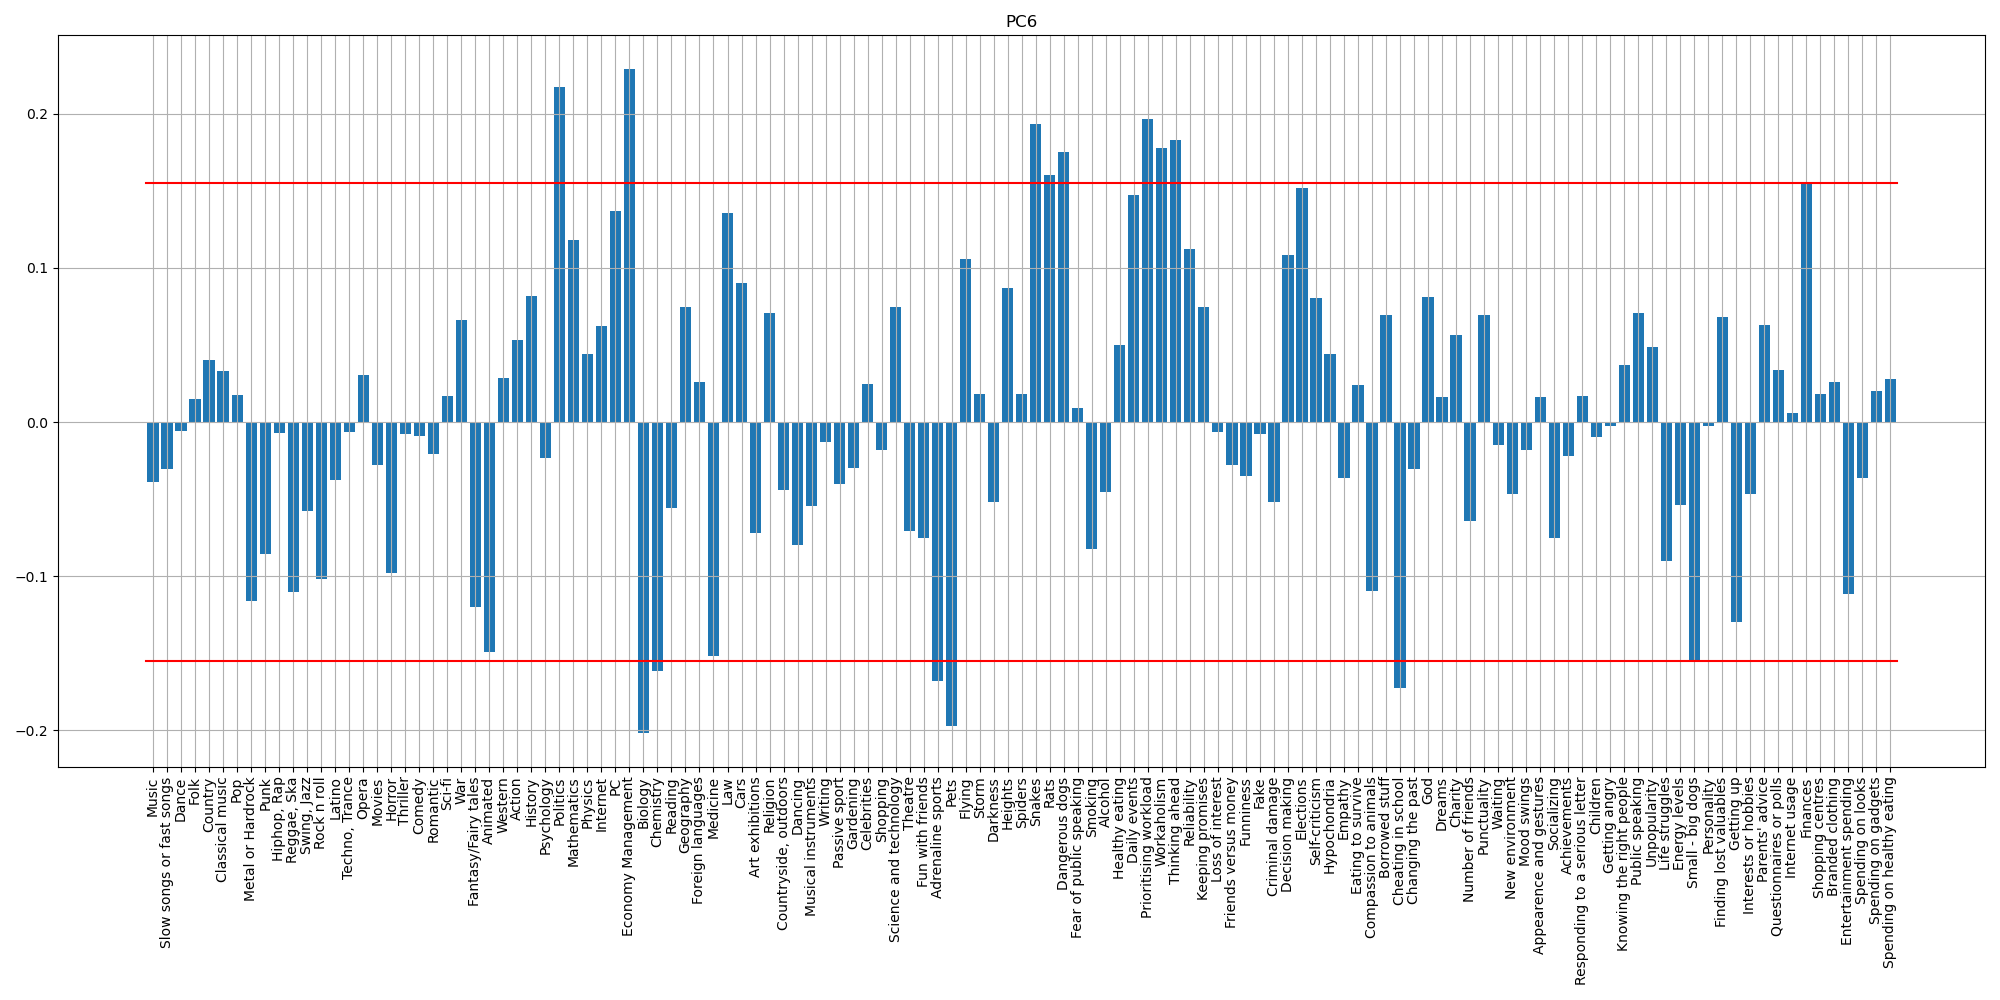


****************** PC6 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Politics', 'Economy Management', 'Snakes', 'Rats', 'Dangerous dogs', 'Prioritising workload', 'Workaholism', 'Thinking ahead']

HIGH-VALUED NEGATIVE COMPONENTS: ['Biology', 'Chemistry', 'Adrenaline sports', 'Pets', 'Cheating in school']
*********************************************



In [121]:
eps = np.sqrt(3/ pca.n_features_)

entertainments=workdf_tot.keys()

for ii in range(m):
    plt.figure(figsize=(20,10))
    plt.bar(np.arange(pca.n_features_), pca.components_[ii, :]) 
    plt.plot([-0.5, pca.n_features_ - 0.5], [eps, eps], 'red')
    plt.plot([-0.5, pca.n_features_ - 0.5], [-eps, -eps], 'red')
    plt.xticks(ticks=np.arange(pca.n_features_),
               labels = entertainments,
               rotation=90)
    plt.title(f'PC{ii + 1}')
    plt.grid()
    plt.tight_layout()
    plt.show()
    ind_great_pos_PCii = np.argwhere(pca.components_[ii, :] >= eps).flatten()
    ind_great_neg_PCii = np.argwhere(pca.components_[ii, :] <= -eps).flatten()
    
    great_pos_PCii = [entertainments[i] for i in ind_great_pos_PCii]
    great_neg_PCii = [entertainments[i] for i in ind_great_neg_PCii]
    
    print('')
    print(f'****************** PC{ii+1} **********************')
    print(f'HIGH-VALUED POSITIVE COMPONENTS: {great_pos_PCii}')
    print('')
    print(f'HIGH-VALUED NEGATIVE COMPONENTS: {great_neg_PCii}')
    print('*********************************************')
    print('')

Following the same strategy that we used before to name the Principal Components, we decided to name them as follows:

1. **PC1 = Life struggle (-) VS Cars (+)**, In this PC the most negative feature is *'Life struggle'*, which characterizes people that cry when things are going bad. While, the most positive feature is *'Cars'*.

1. **PC2 = Classical Music (+)**. The only relevant features are the positive ones, in particular *'Classical music'*, *'musical instruments'* and *'Opera'*;.

1. **PC3 = Rap and branded clothing (-)**. Here, again, the only relevant features are the ones related to Rap music (*'HipPop, rap '*) and expensive clothing (*'Shopping', 'Shopping centers', 'Branded clothing'*, 'Shopping on looks').

1. **PC4 = Science (-) VS Politics (+)**. This PC shows the clear opposition between natural sciences (*'Biology'*, *'Chemistry'*, *'Medicine'*) against politics (*'Politics'*, *'Reading'*). 

1. **PC5 = Happyness (-) VS Sadness (+)**. The most positive feature are related to *bad* attitudes such as *'Criminal Damage'*, *'Changing the past'* and *'Fear of public speaking'*. For the negative features, we see that 'Energy levels' is very high and near the threshold. So we can consider it as an *happyness* state, since we are full-of-energy.

1. **PC6 = Loving animals (-) VS Fearing animals (+)**: The most negative features are related to Biology and the world of animals and nature (*'Biology'*, *'Pets'*, *'Adrenaline sports'*). Instead, the most positve features are related economic subjects (*'Politics'*, *'Economy management'*) and the fear of animals (*'Snakes'*, *'Rats'*, *'Dangerous dogs'*). In order not to make another PC about the dicotomy of Science and Politics, we decided highlight in this case the difference between loving and fearing animals.

In [122]:
# list of the names assigned to the Principal Components
pc_names = ['Life struggle (-) VS Cars (+)',
           'Classical Music (+)',
           'Rap and branded clothing (-)',
           'Science (-) VS Politics (+)',
           'Happyness (-) VS Sadness (+)',
           'Loving animals (-) VS Fearing animals (+)'
           ]

If we  plot the *score graph* with respect to the first three PCs, we can see again that the data cloud is quite uniformly distributed. This means that, even with the added informations in *workdf_tot*, there was not a polarization in the data cloud.

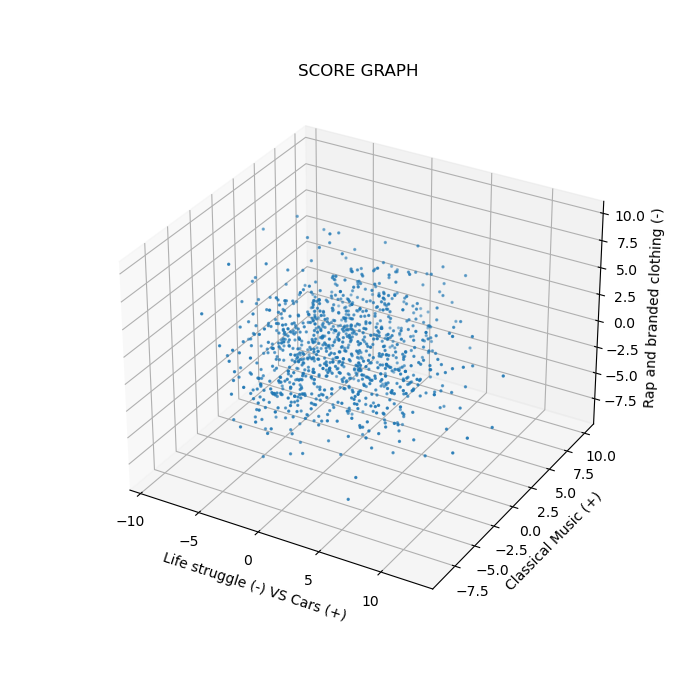

In [123]:
Yentert= pca.transform(workdf_tot)

sg_3d = plt.figure(figsize=(7, 7))
ax_sg_3d = sg_3d.add_subplot(111, projection='3d')
ax_sg_3d.scatter(Yentert[:, 0], Yentert[:, 1], Yentert[:, 2], s=2)

plt.title('SCORE GRAPH')
ax_sg_3d.set_xlabel(pc_names[0])
ax_sg_3d.set_ylabel(pc_names[1])
ax_sg_3d.set_zlabel(pc_names[2])
plt.grid()
plt.show()

### Exercise 10 (*k-means*)

We then apply the *k-means algorithm* to *workdf_tot* with respect to the PC-space. From this operation, we see that the best number of clusters is $k=3$.

In [124]:
km_list = []
silcoeff_list = []
k_list = list(range(3, 10))

for i in range(len(k_list)):
    km_list.append(KMeans(n_clusters=k_list[i], n_init=3, random_state=rs))
    km = km_list[i]
    km.fit(Yentert)
    silcoeff_list.append(silhouette_score(Yentert, km.labels_))

i_best = np.argmax(silcoeff_list)
k = k_list[i_best]
km = km_list[i_best]

print('')
print('')
print('****************** RESULTS OF THE SEARCH... ******************')
print(f'BEST SILHOUETTE SCORE: {np.max(silcoeff_list)} --> k = {k}')
print('**************************************************************')



****************** RESULTS OF THE SEARCH... ******************
BEST SILHOUETTE SCORE: 0.16462098133792247 --> k = 3
**************************************************************


### Exercise 11 (Centroid interpretation and visualization)
At first, we plot the score graph of the points and we highlight the clusters by using differet colors and shapes for each cluster. We then also plot the centroids over the score graph.

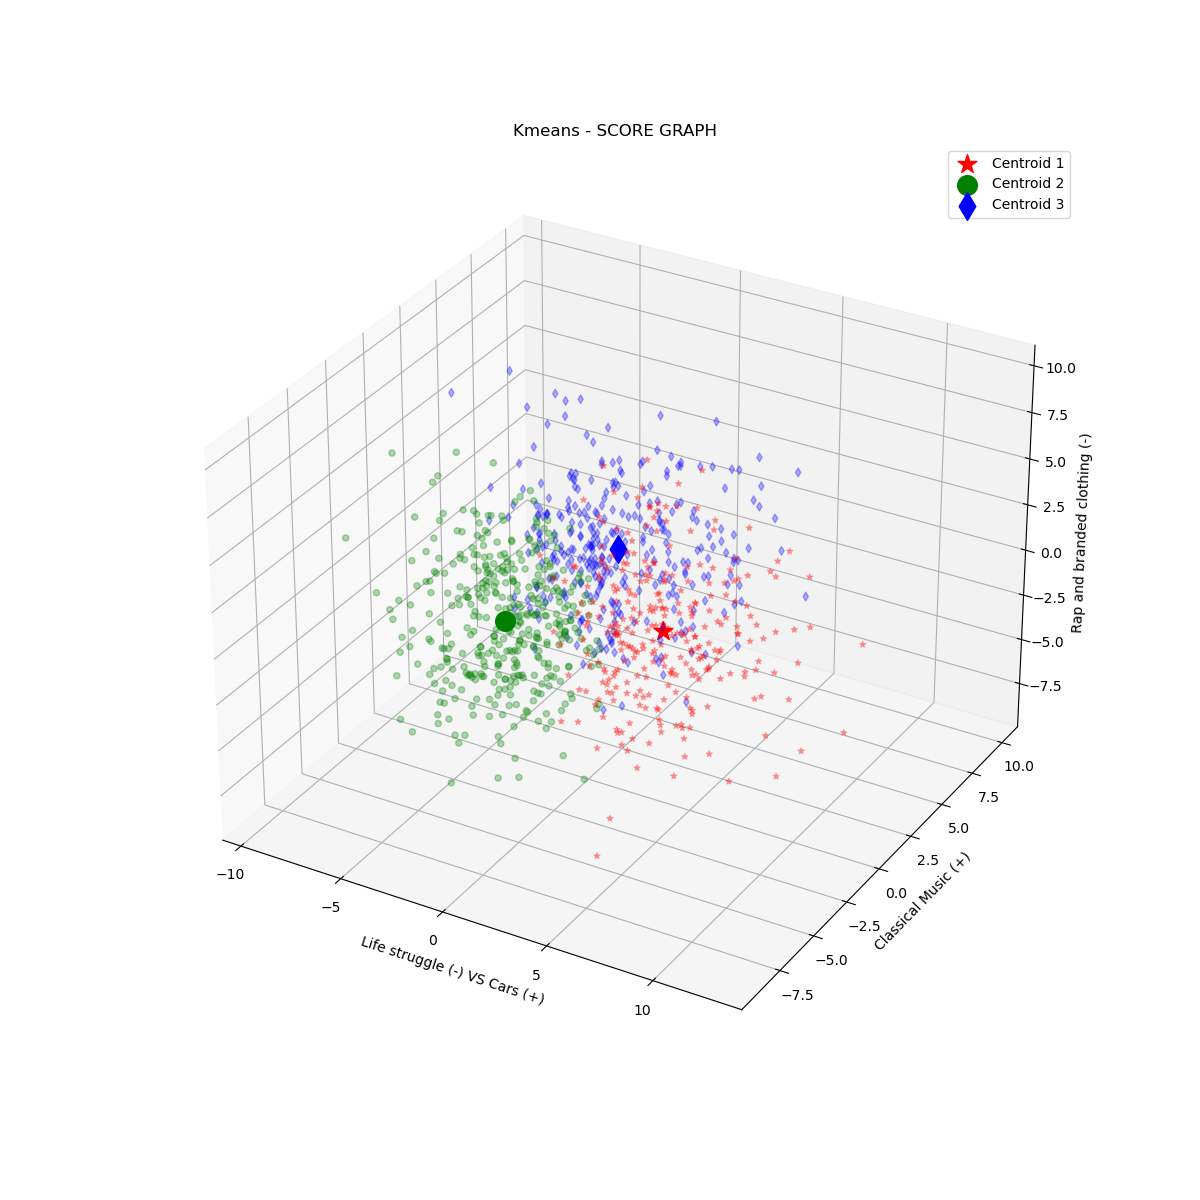

In [125]:
# Plotting the 3d score graph with the centroid

markers_dict = {0: '*', 1: 'o', 2: 'd'}
color_dict = {0: 'red', 1: 'green', 2 : 'blue'}

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

ll = 0
ax.scatter(Yentert[km.labels_ == ll, 0], Yentert[km.labels_ == ll, 1], Yentert[km.labels_ == ll, 2], marker=markers_dict[ll], color = color_dict[ll], alpha = 0.3)

ll = 1
ax.scatter(Yentert[km.labels_ == ll, 0], Yentert[km.labels_ == ll, 1], Yentert[km.labels_ == ll, 2], marker=markers_dict[ll], color = color_dict[ll], alpha = 0.3)

ll = 2
ax.scatter(Yentert[km.labels_ == ll, 0], Yentert[km.labels_ == ll, 1], Yentert[km.labels_ == ll, 2], marker=markers_dict[ll], color = color_dict[ll], alpha = 0.3)

for ll in range(3):
    ax.scatter(km.cluster_centers_[ll, 0], km.cluster_centers_[ll, 1], km.cluster_centers_[ll, 2], 
        color = color_dict[ll], 
        marker= markers_dict[ll], 
        s = 200,
        label = f'Centroid {ll+1}', 
        alpha = 1)

plt.title('Kmeans - SCORE GRAPH')
ax.set_xlabel(pc_names[0])
ax.set_ylabel(pc_names[1])
ax.set_zlabel(pc_names[2])

plt.legend()
plt.grid()
plt.show()

Secondly, we name the centroids by interpreting their components with respect to the 6 Principal Components.

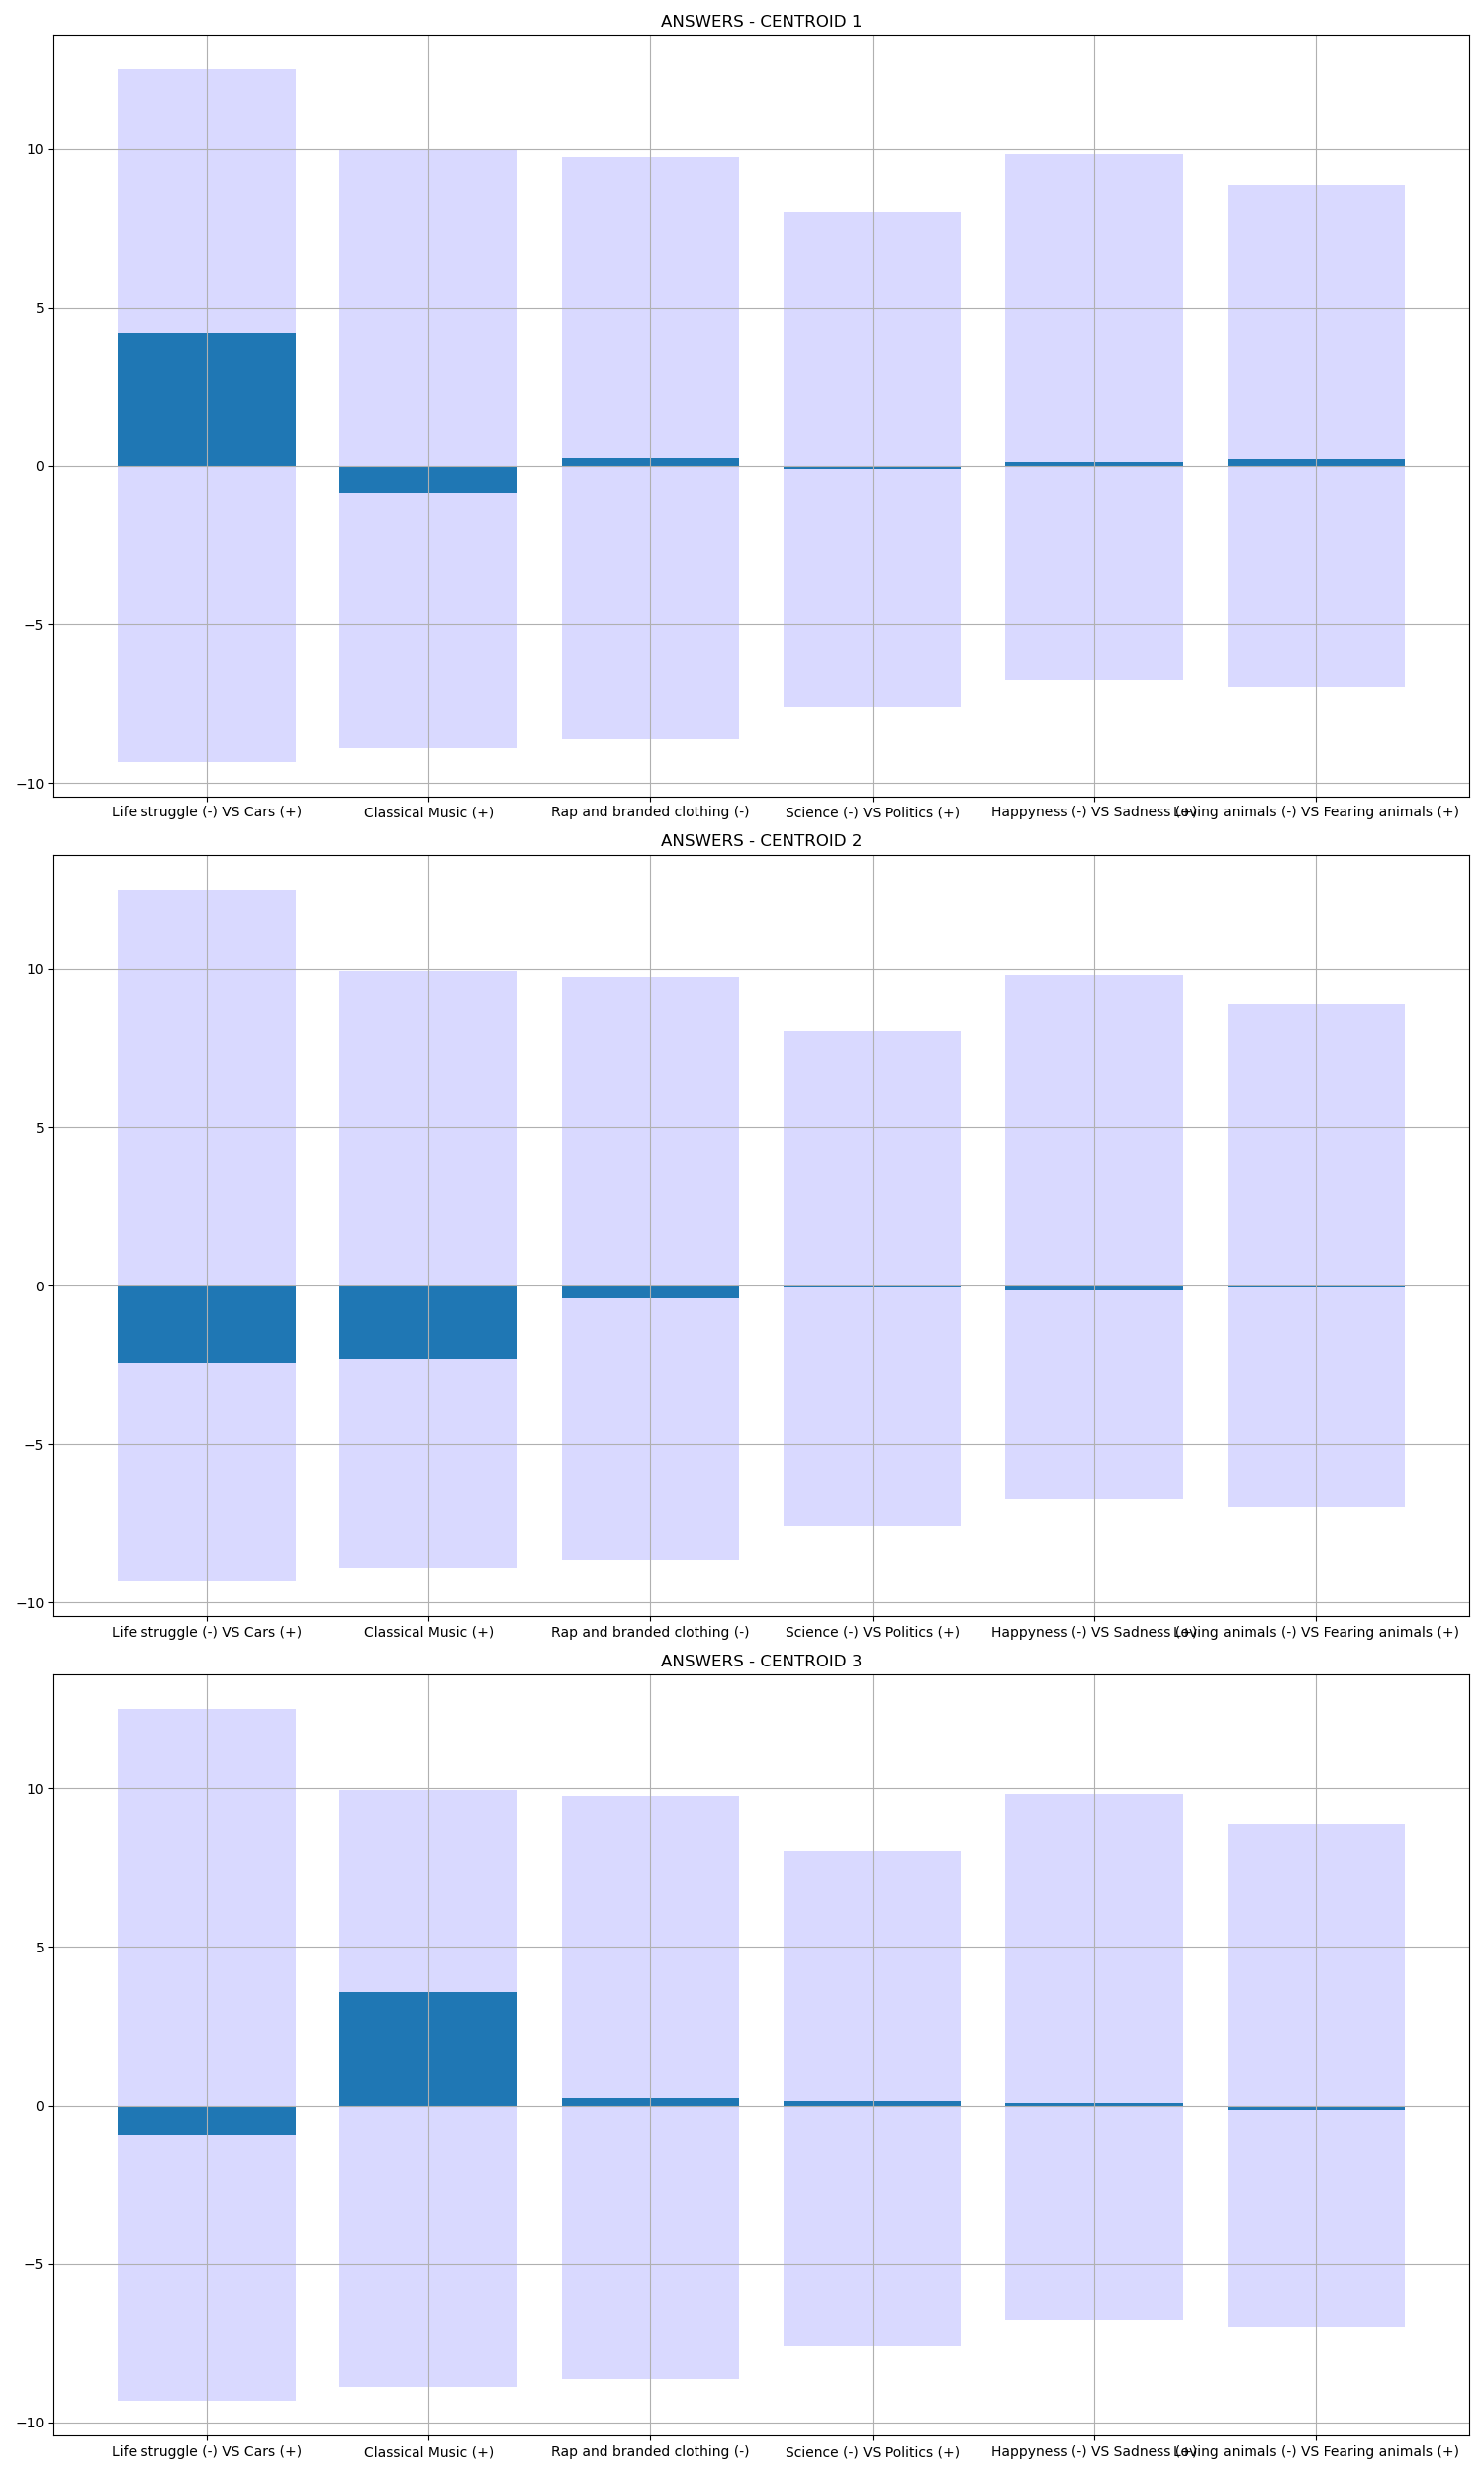

In [126]:
maxs_y = Yentert.max(axis=0) 
mins_y = Yentert.min(axis=0) 

fig_centroids, ax_centroids = plt.subplots(k, 1, figsize=(15, 25))
for ii in range(k):
    ax_centroids[ii].bar(np.arange(km.cluster_centers_.shape[1]), maxs_y, color='blue', alpha=0.15)
    ax_centroids[ii].bar(np.arange(km.cluster_centers_.shape[1]), mins_y, color='blue', alpha=0.15)
    ax_centroids[ii].bar(np.arange(km.cluster_centers_.shape[1]), km.cluster_centers_[ii, :])
    ax_centroids[ii].set_xticks(ticks=np.arange(km.cluster_centers_.shape[1]))
    ax_centroids[ii].set_xticklabels(labels=pc_names, rotation=0)
    ax_centroids[ii].grid(visible=True, which='both')
    plt.tight_layout()
    ax_centroids[ii].set_title(f'ANSWERS - CENTROID {ii+1}')

The names are the following:

1. The first centroid is very passionate of cars above everything else, so we choosed to name it *Car lover*;

1. The second centroid depics a person which has a low self-esteem and that does not like to be in public places like theaters. So we named it *Shy student*;

1. The third centroid is instead characterized by the love for classical music and theater, so we called it an *Artist*.

In [127]:
centroids_names = ['Car lover',
           'Shy student',
           'Artist'
           ]

### Exercise 12 (External evaluation)

Finally, we will discuss the demographical distributions in the clusters of *workdf_tot*. 

Since we have only added more questions and not more students, the distributions of *males/females* and *cities/villages* in the dataframe remain the same.

When analyzing the distribution of males and females among the different clusters, we point out that:

1. the majority of *Car lovers* are males;

1. nearly all the *Shy students* are females;

1. the *Artists* are uniformly distributed between females and males ($60\%$ - $40\%$), recalling the importance of taking into account the global distribution.

Again, the differences between *village* and *city* as *'Home Town Types'* does not bring any relevant differences in the clusters. 

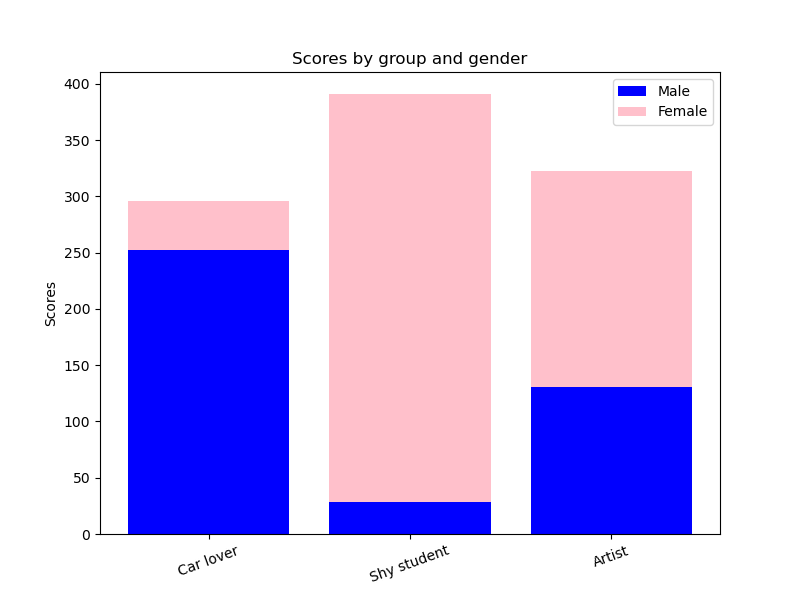

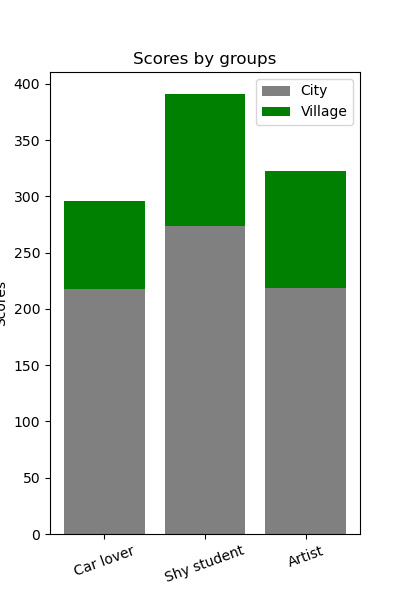

In [128]:
nf = np.zeros(k)
nm = np.zeros(k)

for kk in range(k):
    for ii in range(len(km.labels_)):
        if kk == km.labels_[ii]:
            if demography_df['Gender'].values[ii] == 'female':
                nf[kk] += 1
            else:
                nm[kk] += 1

# THE BARPLOT

fig_mf, ax_mf = plt.subplots(figsize=(8, 6))
ax_mf.bar(centroids_names, nm, label='Male',color='blue')
ax_mf.bar(centroids_names, nf, bottom=nm,
       label='Female',color='pink')
plt.xticks(rotation=20)
ax_mf.set_ylabel('Scores')
ax_mf.set_title('Scores by group and gender')
ax_mf.legend()

plt.show()

ncity = np.zeros(k)
nvil = np.zeros(k)

for kk in range(k):
    for ii in range(len(km.labels_)):
        if kk == km.labels_[ii]:
            if demography_df['Home Town Type'].values[ii] == 'city':
                ncity[kk] += 1
            else:
                nvil[kk] += 1

# THE BARPLOT

fig_cv, ax_cv = plt.subplots(figsize=(4,6))
ax_cv.bar(centroids_names, ncity, label='City',color='grey')   
ax_cv.bar(centroids_names, nvil, bottom=ncity,label='Village',color='green') 
plt.xticks(rotation=20)
ax_cv.set_ylabel('Scores')
ax_cv.set_title('Scores by groups')
ax_cv.legend()

plt.show()